# Code

## Data Preprocessing

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install PyWavelets
import pywt

In [3]:
# Load the dataset
def load_data(file_path):
    """Load dataset from a specified file path."""
    df = pd.read_csv(file_path)
    return df

In [4]:
# Check for null values
def check_null_values(df):
    """Check for null values in the dataframe."""
    print(df.isnull().sum())

In [5]:
# Filter by ion type
def filter_ion(df, ion_type='Sodium'):
    """Filter data by ion type."""
    df_filtered = df[df['Ion'] == ion_type]
    return df_filtered

In [6]:
np.random.seed(42)
# Define a function to add noise to the Drain Current column
def add_noise(df, column='Drain Current', noise_std=0.00001):
    """Add Gaussian noise to the specified column."""
    noisy_df = df[column] + np.random.normal(0, noise_std, len(df))
    df['Noisy ' + column] = noisy_df
    return df

In [7]:
# Define wavelet denoising function
def wavelet_denoise(signal, wavelet='db1', level=1):
    """Apply wavelet denoising to the signal."""
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.std(signal)  # Use standard deviation of the original signal for thresholding
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs[1:]]
    denoised_signal = pywt.waverec(coeffs, wavelet)
    return denoised_signal[:len(signal)]  # Ensure length matches original signal

In [8]:
def add_noise_denoise(df, ion_type='Sodium'):
    """Add noise and denoise the data."""
    user_input = input("Do you want to add noise or not ? (yes/no): ")
    if user_input.lower() != 'yes':
        df_filtered = filter_ion(df, ion_type)
        return df_filtered
    else:
        print("Adding noise and denoising the data...")
        df_filtered = filter_ion(df, ion_type)
        np.random.seed(42)
        # Add noise to the 'Drain Current' column
        df_filtered = add_noise(df_filtered)
        # Apply denoising to the noisy Drain Current
        df_filtered['Drain Current'] = wavelet_denoise(df_filtered['Noisy Drain Current'].values)

        return df_filtered

In [9]:
# Plot bar graph of mean drain current with error bars
# Plot bar graph of mean drain current with error bars
def plot_mean_drain_current(df, ion_type='Sodium'):
    """Plot mean drain current vs concentration for a given ion type with error bars."""
    df_filtered = add_noise_denoise(df, ion_type)
    concentrations = df_filtered['Concentration (mM)'].unique()
    mean_drain_current = []
    std_drain_current = []

    for concentration in concentrations:
        df_conc = df_filtered[df_filtered['Concentration (mM)'] == concentration]
        mean_drain_current.append(df_conc['Drain Current'].mean())
        std_drain_current.append(df_conc['Drain Current'].std())

    # Plotting
    colors = sns.color_palette("hsv", len(concentrations))
    plt.figure(figsize=(10, 6))
    bar_positions = np.arange(len(concentrations))
    plt.bar(bar_positions, mean_drain_current, yerr=std_drain_current, color=colors, edgecolor='black', capsize=5)
    plt.xlabel('Concentration (mM)')
    plt.ylabel('Mean Drain Current (A)')
    plt.title(f'Mean Drain Current vs. Concentration for {ion_type}')
    plt.xticks(bar_positions, concentrations)
    plt.gca().invert_yaxis()  # Reverse the y-axis
    plt.show()

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_response(df, ion_type='Sodium'):
    """Calculate and plot the response vs concentration with error bars."""
    df_filtered = add_noise_denoise(df, ion_type)
    concentrations = df_filtered['Concentration (mM)'].unique()
    mean_drain_current = []
    std_drain_current = []

    # Calculate mean and standard deviation for each concentration
    for concentration in concentrations:
        df_conc = df_filtered[df_filtered['Concentration (mM)'] == concentration]
        mean_drain_current.append(df_conc['Drain Current'].mean())
        std_drain_current.append(df_conc['Drain Current'].std())

    response = []
    response_std = []

    # Set I0 for the first concentration (20.0 mM)
    I0 = -0.001  # Fixed value for the first concentration

    # Calculate response for the first concentration (20.0 mM)
    initial_mean = mean_drain_current[0]  # This corresponds to 20.0 mM
    resp = (initial_mean - I0) / I0
    response.append(resp)
    response_std.append(0)  # No error for the initial baseline

    # Print I0 and I values for the first concentration
    print(f"Concentration: {concentrations[0]} mM, I0: {I0:.4f}, I: {initial_mean:.4f}")

    # For each subsequent concentration, calculate response and update I0 accordingly
    for i in range(1, len(mean_drain_current)):
        I = mean_drain_current[i]
        std_I = std_drain_current[i]

        # Update I0 to be the mean current of the previous concentration
        I0 = mean_drain_current[i-1]  # Set I0 to the mean of the previous concentration

        # Calculate response and response standard deviation
        resp = (I - I0) / I0
        response.append(resp)

        # Estimate standard deviation for response and ensure non-negative values
        resp_std = abs(resp * np.sqrt((std_I / I)**2 + (std_drain_current[i-1] / I0)**2))
        response_std.append(resp_std)

        # Print I0 and I values for each concentration
        print(f"Concentration: {concentrations[i]} mM, I0: {I0:.4f}, I: {I:.4f}")

    # Generate colors for each concentration
    colors = sns.color_palette("hsv", len(concentrations))  # Use 'hsv' palette for diverse colors

    # Plot Response with Error Bars
    plt.figure(figsize=(10, 6))
    response_positions = np.arange(len(concentrations))
    plt.bar(response_positions, response, yerr=response_std, color=colors, edgecolor='black', capsize=5)
    plt.xlabel('Concentration (mM)')
    plt.ylabel('Response (I - I0 / I0)')
    plt.title('Response vs. Concentration')
    plt.xticks(response_positions, concentrations)
    plt.gca().invert_yaxis()  # Invert y-axis if needed
    plt.show()

In [11]:
# Create continuous time series for plotting
def create_continuous_time(df, ion_type='Sodium'):
    """
    Create a continuous time series starting from the lowest concentration at 0s
    and ending with the highest concentration.
    """
    df_filtered = add_noise_denoise(df, ion_type)
    df_sorted = df_filtered.sort_values(['Concentration (mM)', 'Drain Time'], ascending=[True, True])
    concentrations = sorted(df_filtered['Concentration (mM)'].unique())

    # Initialize variables
    modified_data = []
    current_time_offset = 0

    for conc in concentrations:
        # Select data for the current concentration and sort by Drain Time
        conc_df = df_sorted[df_sorted['Concentration (mM)'] == conc].copy()

        # Calculate new continuous time with current offset
        conc_df['Continuous Time'] = conc_df['Drain Time'] + current_time_offset

        # Print the time series range for each concentration
        start_time = conc_df['Continuous Time'].min()
        end_time = conc_df['Continuous Time'].max()
        print(f"Concentration {conc} mM: Time range from {start_time} to {end_time}")

        # Update the offset for the next concentration
        current_time_offset = end_time + 1  # Increment offset for next concentration

        # Append modified data
        modified_data.append(conc_df)

    return pd.concat(modified_data, ignore_index=True)

In [12]:

# Plot step graph of Current vs. Continuous Time
def plot_step_current_vs_time(df, ion_type='Sodium'):
    """
    Plot a step graph of Current vs. Continuous Time,
    using the updated time series starting at the lowest concentration.
    """
    # Generate the continuous time data
    continuous_data = create_continuous_time(df, ion_type)

    # Sort by Continuous Time to plot properly
    continuous_data = continuous_data.sort_values(by='Continuous Time')

    plt.figure(figsize=(12, 6))

    # Plot the step graph with normal values for the current
    for concentration, group_data in continuous_data.groupby('Concentration (mM)'):
        plt.step(
            group_data['Continuous Time'],
            group_data['Drain Current'],  # Use normal current values (no abs())
            where='post',
            label=f'{concentration} mM',
            linewidth=2
        )

    plt.xlabel('Continuous Time (s)')
    plt.ylabel('Current (A)')
    plt.title(f'Continuous Step Plot of Current vs. Time for {ion_type}')
    plt.legend(title='Concentration (mM)')
    plt.grid(True)
    plt.show()


Gate Voltage          0
Gate Current          0
Gate Time             0
Drain Voltage         0
Drain Current         0
Drain Time            0
Concentration (mM)    0
Ion                   0
dtype: int64
Do you want to add noise or not ? (yes/no): no


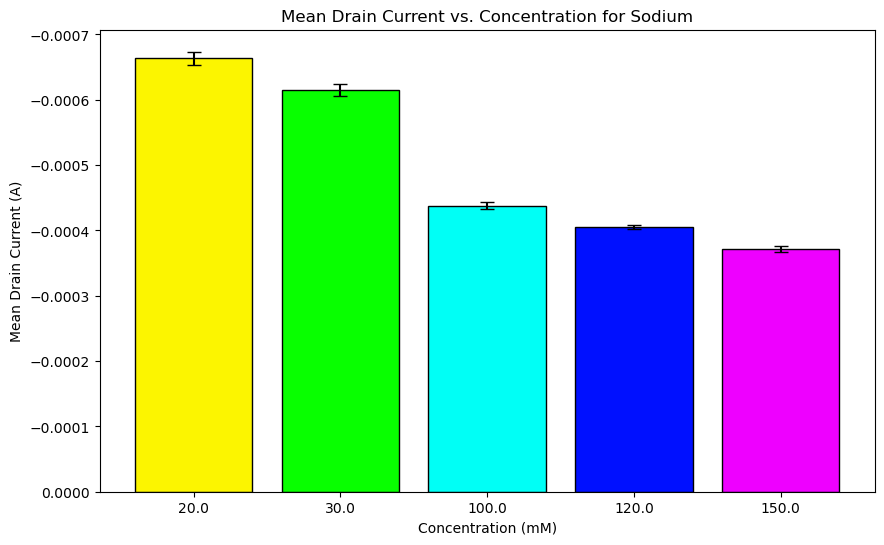

In [13]:

# Example usage
#file_path = "/content/drive/MyDrive/BTP/Combined_data(0.25,150).csv"
#file_path = "/content/drive/MyDrive/BTP/DATASET_4.csv"
#file_path = "/content/drive/MyDrive/BTP/BTP_FinalDataa1.csv"
file_path = r"C:\Users\pujar_rd15uog\Downloads\BTP\BTP_FinalDataa1.csv"
df = load_data(file_path)
check_null_values(df)
ion_type = 'Sodium'
plot_mean_drain_current(df, ion_type)

Do you want to add noise or not ? (yes/no): no
Concentration: 20.0 mM, I0: -0.0010, I: -0.0007
Concentration: 30.0 mM, I0: -0.0007, I: -0.0006
Concentration: 100.0 mM, I0: -0.0006, I: -0.0004
Concentration: 120.0 mM, I0: -0.0004, I: -0.0004
Concentration: 150.0 mM, I0: -0.0004, I: -0.0004


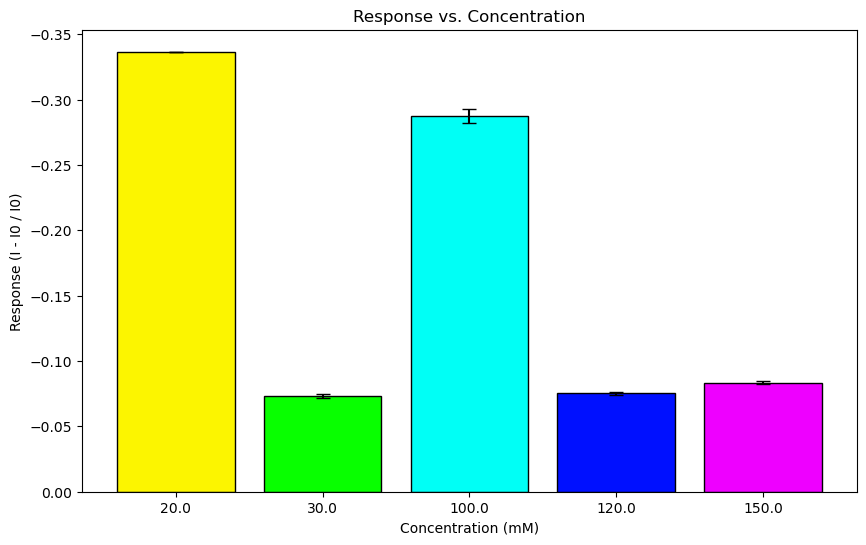

In [14]:
plot_response(df, ion_type)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_response1(df, ion_type='Sodium'):
    """Calculate and plot the response vs concentration with error bars."""
    df_filtered = add_noise_denoise(df, ion_type)
    concentrations = df_filtered['Concentration (mM)'].unique()
    mean_drain_current = []
    std_drain_current = []

    # Calculate mean and standard deviation for each concentration
    for concentration in concentrations:
        df_conc = df_filtered[df_filtered['Concentration (mM)'] == concentration]
        mean_drain_current.append(df_conc['Drain Current'].mean())
        std_drain_current.append(df_conc['Drain Current'].std())

    response = []
    response_std = []

    # Set I0 to a constant value of -0.001 for all concentrations
    I0 = -0.001

    # Calculate responses for each concentration using the constant I0
    for i in range(len(mean_drain_current)):
        I = mean_drain_current[i]
        std_I = std_drain_current[i]

        # Calculate response and response standard deviation
        resp = (I - I0) / I0
        response.append(resp)

        # Estimate standard deviation for response and ensure non-negative values
        resp_std = abs(resp * np.sqrt((std_I / I)**2 + (std_drain_current[i] / I0)**2))
        response_std.append(resp_std)

        # Print I0 and I values for each concentration
        print(f"Concentration: {concentrations[i]} mM, I0: {I0:.4f}, I: {I:.4f}")

    # Generate colors for each concentration
    colors = sns.color_palette("tab10", len(concentrations))  # Use 'hsv' palette for diverse colors

    # Plot Response with Error Bars
    plt.figure(figsize=(10, 6))
    response_positions = np.arange(len(concentrations))
    plt.bar(response_positions, response, yerr=response_std, color=colors, edgecolor='black', capsize=5)
    plt.xlabel('Concentration (mM)')
    plt.ylabel('Response (I - I0 / I0)')
    plt.title('Response vs. Concentration with Constant I0')
    plt.xticks(response_positions, concentrations)
    plt.gca().invert_yaxis()  # Invert y-axis if needed
    plt.show()

Do you want to add noise or not ? (yes/no): no
Concentration: 20.0 mM, I0: -0.0010, I: -0.0007
Concentration: 30.0 mM, I0: -0.0010, I: -0.0006
Concentration: 100.0 mM, I0: -0.0010, I: -0.0004
Concentration: 120.0 mM, I0: -0.0010, I: -0.0004
Concentration: 150.0 mM, I0: -0.0010, I: -0.0004


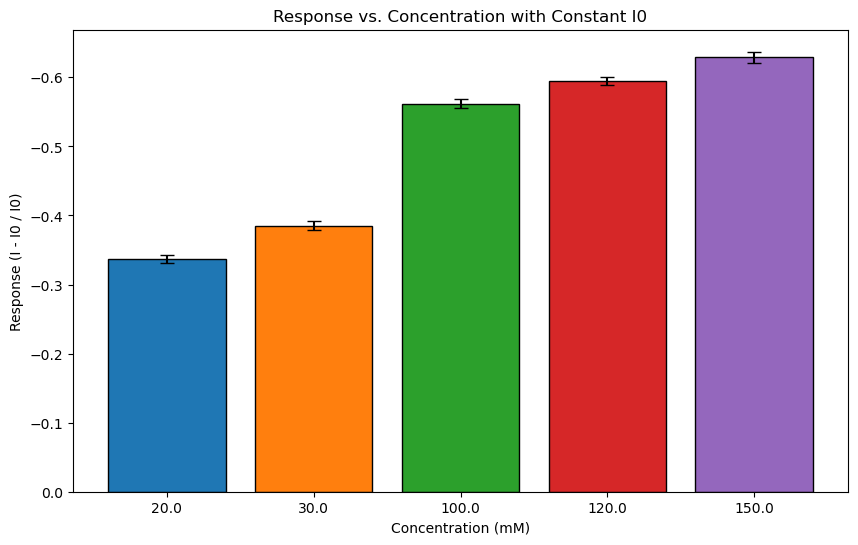

In [16]:
plot_response1(df, ion_type)

In [17]:
df_filtered = add_noise_denoise(df, ion_type)
df_filtered.head()

Do you want to add noise or not ? (yes/no): no


,Gate Voltage,Gate Current,Gate Time,Drain Voltage,Drain Current,Drain Time,Concentration (mM),Ion
0,-0.4,-0.000002,0.0,-0.5,-0.000679,0.0,20.0,Sodium
1,-0.4,-0.000002,0.5,-0.5,-0.000679,0.5,20.0,Sodium
2,-0.4,-0.000002,1.0,-0.5,-0.000679,1.0,20.0,Sodium
3,-0.4,-0.000001,1.5,-0.5,-0.000680,1.5,20.0,Sodium
4,-0.4,-0.000002,2.0,-0.5,-0.000680,2.0,20.0,Sodium


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def plot_response_with_fit(df, ion_type='Sodium'):
    """Calculate, plot response with linear fit, and determine LOD."""
    # Filter data and calculate response as before
    df_filtered = add_noise_denoise(df, ion_type)
    concentrations = df_filtered['Concentration (mM)'].unique()
    mean_drain_current = []
    std_drain_current = []

    # Calculate mean and std of drain current for each concentration
    for concentration in concentrations:
        df_conc = df_filtered[df_filtered['Concentration (mM)'] == concentration]
        mean_drain_current.append(df_conc['Drain Current'].mean())
        std_drain_current.append(df_conc['Drain Current'].std())

    # Initialize Io and calculate response for each concentration
    I0 = -0.001  # Adjusted baseline current for response calculation
    response = []
    response_std = []

    for i, I in enumerate(mean_drain_current):
        resp = (I - I0) / I0
        response.append(resp)
        resp_std = abs(resp * np.sqrt((std_drain_current[i] / I)**2 + (std_drain_current[0] / I0)**2))
        response_std.append(resp_std)

    # Linear fit
    log_concentrations = np.log10(concentrations)  # Logarithmic scale for concentrations
    slope, intercept, r_value, _, std_err = linregress(log_concentrations, response)

    # Calculate LOD
    lod = 3 * np.mean(response_std) / slope  # LOD calculation based on slope and std

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.errorbar(log_concentrations, response, yerr=response_std, fmt='s', color='black', label='Response')
    plt.plot(log_concentrations, intercept + slope * log_concentrations, 'r-', label=f'Linear Fit (R-Square {r_value**2:.4f})')

    # Annotate with equation, slope, intercept, R^2
    #plt.text(0.05, 0.95, f'Equation: y = {intercept:.2f} + {slope:.2f} * x\nIntercept: {intercept:.2f}\nSlope: {slope:.2f}\nR-Square: {r_value**2:.4f}',
             #transform=plt.gca().transAxes, verticalalignment='top')
    # Annotate with equation, slope, intercept, R^2 in a text box with background
    # Annotate with equation, slope, intercept, R^2 in a text box at the bottom left
    textstr = f'Equation: y = {intercept:.2f} + {slope:.2f} * x\nIntercept: {intercept:.2f}\nSlope: {slope:.2f}\nR-Square: {r_value**2:.4f}'
    plt.text(0.05, 0.05, textstr, transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='bottom', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.7))


    plt.xlabel('Concentration (log10 scale, mM)')
    plt.ylabel('Response (I - I0 / I0)')
    plt.title(f'Response vs. Concentration for {ion_type} with Linear Fit')
    plt.legend()
    plt.show()

    print(f"Limit of Detection (LOD): {lod:.4f} mM")

# Call the function with your DataFrame


Do you want to add noise or not ? (yes/no): no


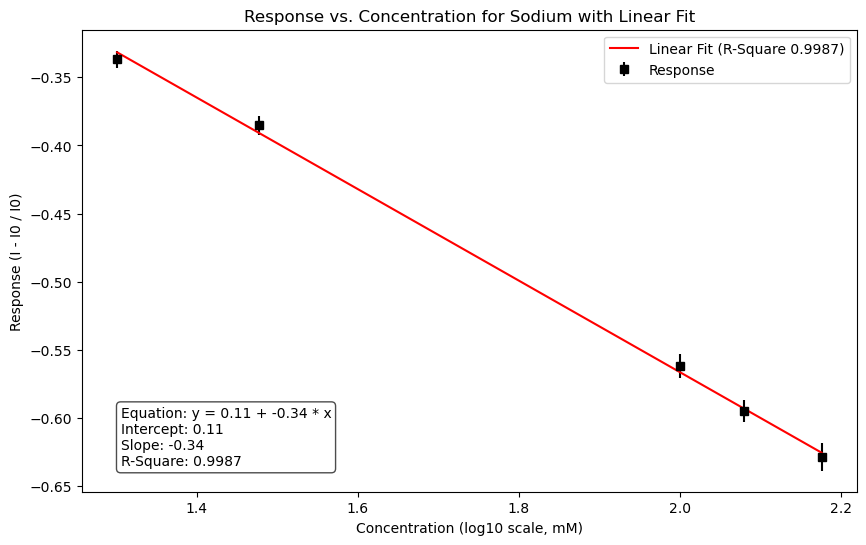

Limit of Detection (LOD): -0.0712 mM


In [19]:
plot_response_with_fit(df, ion_type='Sodium')

In [20]:
def plot_sensitivity_curve(df, ion_type='Sodium'):
    """Calculate and plot the sensitivity curve."""
    df_filtered = add_noise_denoise(df, ion_type)
    concentrations = df_filtered['Concentration (mM)'].unique()
    mean_drain_current = []

    # Calculate mean drain current for each concentration
    for concentration in concentrations:
        df_conc = df_filtered[df_filtered['Concentration (mM)'] == concentration]
        mean_drain_current.append(df_conc['Drain Current'].mean())

    # Calculate response as (I - I0) / I0 with a fixed I0
    I0 = -0.001  # Baseline current
    response = [(I - I0) for I in mean_drain_current]

    # Calculate sensitivity (delta response / delta concentration)
    sensitivities = []
    concentration_midpoints = []
    for i in range(1, len(response)):
        delta_response = response[i] - response[i - 1]
        delta_concentration = concentrations[i] - concentrations[i - 1]
        sensitivities.append(delta_response / delta_concentration)
        concentration_midpoints.append((concentrations[i] + concentrations[i - 1]) / 2)

    # Plot the sensitivity curve
    plt.figure(figsize=(10, 6))
    plt.plot(concentration_midpoints, sensitivities, 'o-', color='blue', label='Sensitivity')
    plt.xlabel('Concentration (mM)')
    plt.ylabel('Sensitivity (ΔResponse / ΔConcentration)')
    plt.title(f'Sensitivity Curve for {ion_type} Sensor')
    plt.legend()
    plt.show()

# Call the function with your DataFrame



Do you want to add noise or not ? (yes/no): no


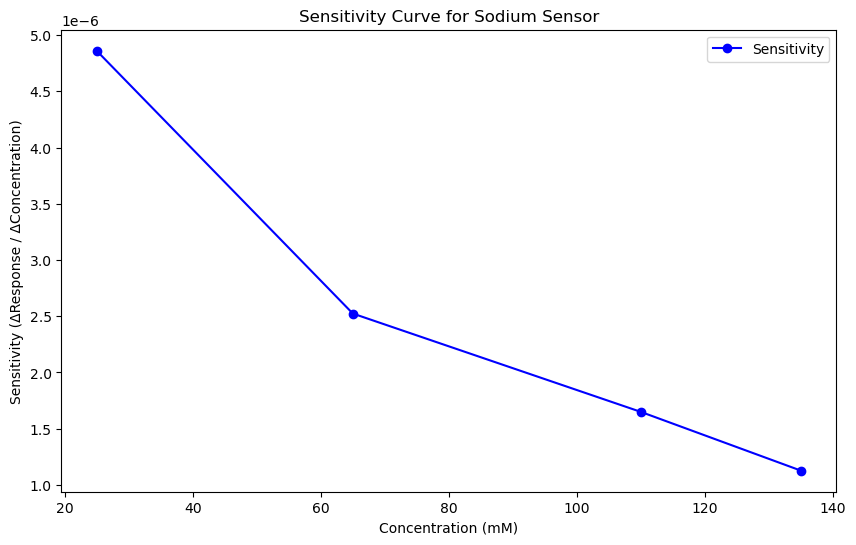

In [21]:
plot_sensitivity_curve(df, ion_type='Sodium')

In [22]:
def plot_individual_sensitivity1(df, ion_type='Sodium'):
    """Calculate and plot individual sensitivity points vs concentration."""
    df_filtered = add_noise_denoise(df, ion_type)

    # Set the baseline current I0 slightly below the lowest concentration mean drain current
    initial_mean_drain_current = df_filtered[df_filtered['Concentration (mM)'] == df_filtered['Concentration (mM)'].min()]['Drain Current'].mean()
    I0 = -0.001  # Adjusted baseline current

    # Calculate individual sensitivity for each data point
    df_filtered['Sensitivity'] = (df_filtered['Drain Current'] - I0) / df_filtered['Concentration (mM)']

    # Plotting each sensitivity point against its concentration
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_filtered, x='Concentration (mM)', y='Sensitivity', hue='Concentration (mM)', palette="hsv", legend=False)
    plt.xlabel('Concentration (mM)')
    plt.ylabel('Sensitivity (ΔI / Concentration)')
    plt.title(f'Individual Sensitivity Points vs. Concentration for {ion_type}')
    plt.show()

# Call the function with your DataFrame
#

Do you want to add noise or not ? (yes/no): no


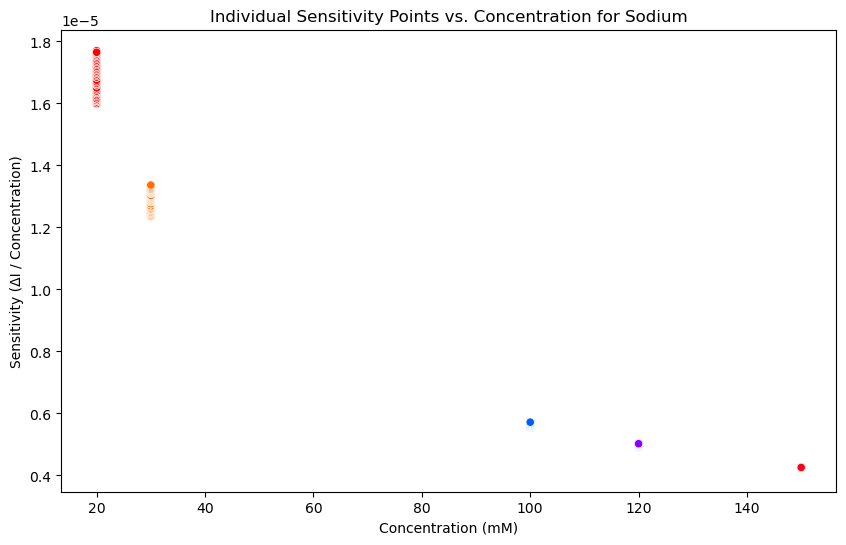

In [23]:
plot_individual_sensitivity1(df, ion_type='Sodium')


Do you want to add noise or not ? (yes/no): no
Concentration 20.0 mM: Time range from 0.0 to 78.0
Concentration 30.0 mM: Time range from 79.0 to 151.0
Concentration 100.0 mM: Time range from 152.0 to 229.0
Concentration 120.0 mM: Time range from 230.0 to 310.0
Concentration 150.0 mM: Time range from 311.0 to 402.0


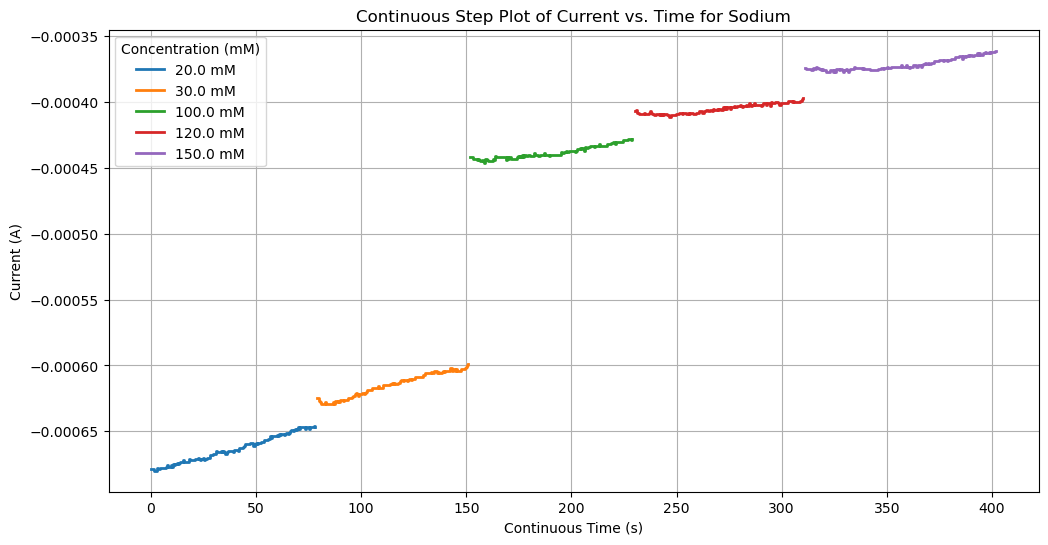

In [24]:
plot_step_current_vs_time(df, ion_type='Sodium')

## Machine Learning Models

In [25]:
create_continuous_time(df, ion_type)

Do you want to add noise or not ? (yes/no): no
Concentration 20.0 mM: Time range from 0.0 to 78.0
Concentration 30.0 mM: Time range from 79.0 to 151.0
Concentration 100.0 mM: Time range from 152.0 to 229.0
Concentration 120.0 mM: Time range from 230.0 to 310.0
Concentration 150.0 mM: Time range from 311.0 to 402.0


,Gate Voltage,Gate Current,Gate Time,Drain Voltage,Drain Current,Drain Time,Concentration (mM),Ion,Continuous Time
0,-0.4,-1.900000e-06,0.0,-0.5,-0.000679,0.0,20.0,Sodium,0.0
1,-0.4,-1.900000e-06,0.5,-0.5,-0.000679,0.5,20.0,Sodium,0.5
2,-0.4,-1.600000e-06,1.0,-0.5,-0.000679,1.0,20.0,Sodium,1.0
3,-0.4,-1.400000e-06,1.5,-0.5,-0.000680,1.5,20.0,Sodium,1.5
4,-0.4,-1.600000e-06,2.0,-0.5,-0.000680,2.0,20.0,Sodium,2.0
...,...,...,...,...,...,...,...,...,...
796,-0.4,-1.800000e-06,89.0,-0.5,-0.000362,89.0,150.0,Sodium,400.0
797,-0.4,-9.000000e-07,89.5,-0.5,-0.000362,89.5,150.0,Sodium,400.5
798,-0.4,-1.600000e-06,90.0,-0.5,-0.000362,90.0,150.0,Sodium,401.0
799,-0.4,-2.200000e-06,90.5,-0.5,-0.000361,90.5,150.0,Sodium,401.5


In [26]:
columns = ['Drain Current','Concentration (mM)','Continuous Time']
def data_create(data):
  df1 = create_continuous_time(df, ion_type)[columns]
  return df1

In [27]:
data = data_create(df)
# Prepare data by removing the 'Concentration (mM)' column for clustering
original_labels = data['Concentration (mM)']
n = len(np.unique(original_labels))
data_for_clustering = data.drop(columns=['Concentration (mM)'])
data_for_clustering

Do you want to add noise or not ? (yes/no): no
Concentration 20.0 mM: Time range from 0.0 to 78.0
Concentration 30.0 mM: Time range from 79.0 to 151.0
Concentration 100.0 mM: Time range from 152.0 to 229.0
Concentration 120.0 mM: Time range from 230.0 to 310.0
Concentration 150.0 mM: Time range from 311.0 to 402.0


,Drain Current,Continuous Time
0,-0.000679,0.0
1,-0.000679,0.5
2,-0.000679,1.0
3,-0.000680,1.5
4,-0.000680,2.0
...,...,...
796,-0.000362,400.0
797,-0.000362,400.5
798,-0.000362,401.0
799,-0.000361,401.5


In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, silhouette_score

def evaluate_and_display_results(original_labels, predicted_labels, data, model_name):
    # Step 1: Create a DataFrame to display clustering results
    data = data_create(df)
    results_df = data.copy()
    results_df['Predicted_Cluster'] = predicted_labels

    # Step 2: Create a mapping of predicted clusters to their corresponding majority concentrations
    cluster_mapping = results_df.groupby('Predicted_Cluster')['Concentration (mM)'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)

    # Step 3: Replace predicted cluster labels with their corresponding majority concentrations
    predicted_concentrations = [cluster_mapping[label] for label in predicted_labels]

    # Calculate evaluation metrics using actual concentrations vs. predicted concentrations
    ari_score = adjusted_rand_score(original_labels, predicted_concentrations)
    silhouette_avg = silhouette_score(data, predicted_labels)

    print(f"Metrics for {model_name}:")
    print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
    print(f"Silhouette Score: {silhouette_avg:.4f}\n")

    # Confusion matrix-style heatmap for distribution
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Create confusion DataFrame using actual and mapped predicted concentrations
    confusion_data = pd.DataFrame({'Actual': original_labels, 'Predicted': predicted_concentrations})

    # Count occurrences of each combination of actual and predicted labels
    confusion_counts = confusion_data.groupby(['Actual', 'Predicted']).size().unstack(fill_value=0)

    # Plotting the confusion matrix-style heatmap
    sns.heatmap(confusion_counts, annot=True, fmt='d', cmap='YlOrRd', ax=ax[0])
    ax[0].set_title(f'{model_name} - Prediction Distribution')
    ax[0].set_xlabel('Predicted Concentration (mM)')
    ax[0].set_ylabel('Actual Concentration (mM)')

    # Scatter plot for prediction accuracy with error bands
    mean_pred = pd.DataFrame({
        'true': original_labels,
        'pred': predicted_concentrations
    }).groupby('true')['pred'].agg(['mean', 'std']).reset_index()

    ax[1].scatter(original_labels, predicted_concentrations, alpha=0.5, color='blue')

    # Perfect prediction line
    ax[1].plot([min(original_labels), max(original_labels)],
               [min(original_labels), max(original_labels)],
               'r--', label='Perfect Prediction')

    # Calculate and plot error bands (±1 std deviation)
    ax[1].fill_between(mean_pred['true'],
                       mean_pred['mean'] - mean_pred['std'],
                       mean_pred['mean'] + mean_pred['std'],
                       alpha=0.2, color='orange', label='±1 std dev')

    ax[1].set_title('Prediction Accuracy\n(Points on red line = perfect prediction)')
    ax[1].set_xlabel('Actual Concentration (mM)')
    ax[1].set_ylabel('Predicted Concentration (mM)')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# evaluate_and_display_results(original_labels, final_kmeans_labels, data_for_clustering, "K-Means Clustering")

#### PCA Plot

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

def plot_clusters_pca(data, original_labels, predicted_labels, model_name):
    # Perform PCA to reduce dimensions
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    # Create a color map for the original labels (concentrations)
    unique_concentrations = np.unique(original_labels)
    concentration_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_concentrations)))

    # Create a color map for the predicted labels (clusters)
    unique_clusters = np.unique(predicted_labels)
    cluster_colors = plt.cm.plasma(np.linspace(0, 1, len(unique_clusters)))

    plt.figure(figsize=(12, 6))

    # Plot True Concentration Clusters
    plt.subplot(1, 2, 1)
    for i, conc in enumerate(unique_concentrations):
        mask = original_labels == conc
        plt.scatter(reduced_data[mask, 0], reduced_data[mask, 1],
                    color=concentration_colors[i], label=f'Concentration {conc} mM', s=50)

    plt.title(f'{model_name} - True Concentration Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')

    # Adjust legend size and position
    plt.legend(title='Concentration (mM)', loc='best', fontsize='small', title_fontsize='medium')

    # Plot Predicted Clusters
    plt.subplot(1, 2, 2)
    for i, cluster_num in enumerate(unique_clusters):
        mask = predicted_labels == cluster_num
        plt.scatter(reduced_data[mask, 0], reduced_data[mask, 1],
                    color=cluster_colors[i], label=f'Predicted Cluster {cluster_num}', s=50)

    plt.title(f'{model_name} - Predicted Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')

    # Adjust legend size and position
    plt.legend(title='Predicted Labels', loc='best', fontsize='small', title_fontsize='medium')

    plt.tight_layout()
    plt.show()

#### Current Vs Time

In [30]:
import matplotlib.pyplot as plt

def plot_time_series_clusters(data, original_labels, predicted_labels, model_name):
    plt.figure(figsize=(14, 6))

    # Plot True Concentration Time Series
    plt.subplot(1, 2, 1)
    scatter1 = plt.scatter(data['Continuous Time'], data['Drain Current'],
                           c=original_labels, cmap='tab20', s=50)
    plt.title(f'{model_name} - True Concentration Time Series')
    plt.xlabel('Continuous Time')
    plt.ylabel('Drain Current')

    # Create a legend for true concentrations
    legend1 = plt.legend(*scatter1.legend_elements(), title='Concentration (mM)', loc='best', fontsize='small', title_fontsize='medium')
    plt.gca().add_artist(legend1)  # Add legend to the plot

    # Plot Predicted Time Series Clusters
    plt.subplot(1, 2, 2)
    scatter2 = plt.scatter(data['Continuous Time'], data['Drain Current'],
                           c=predicted_labels, cmap='tab20b', s=50)
    plt.title(f'{model_name} - Predicted Time Series Clusters')
    plt.xlabel('Continuous Time')
    plt.ylabel('Drain Current')

    # Create a legend for predicted labels
    legend2 = plt.legend(*scatter2.legend_elements(), title='Predicted Labels', loc='best', fontsize='small', title_fontsize='medium')
    plt.gca().add_artist(legend2)  # Add legend to the plot

    plt.tight_layout()
    plt.show()

#### Gaussian Mixture

Best params for Gaussian Mixture Model: {'n_components': 5, 'covariance_type': 'spherical'} with Silhouette Score: 0.5596604225265852
Do you want to add noise or not ? (yes/no): no
Concentration 20.0 mM: Time range from 0.0 to 78.0
Concentration 30.0 mM: Time range from 79.0 to 151.0
Concentration 100.0 mM: Time range from 152.0 to 229.0
Concentration 120.0 mM: Time range from 230.0 to 310.0
Concentration 150.0 mM: Time range from 311.0 to 402.0
Metrics for Gaussian Mixture Model:
Adjusted Rand Index (ARI): 0.7878
Silhouette Score: 0.5577



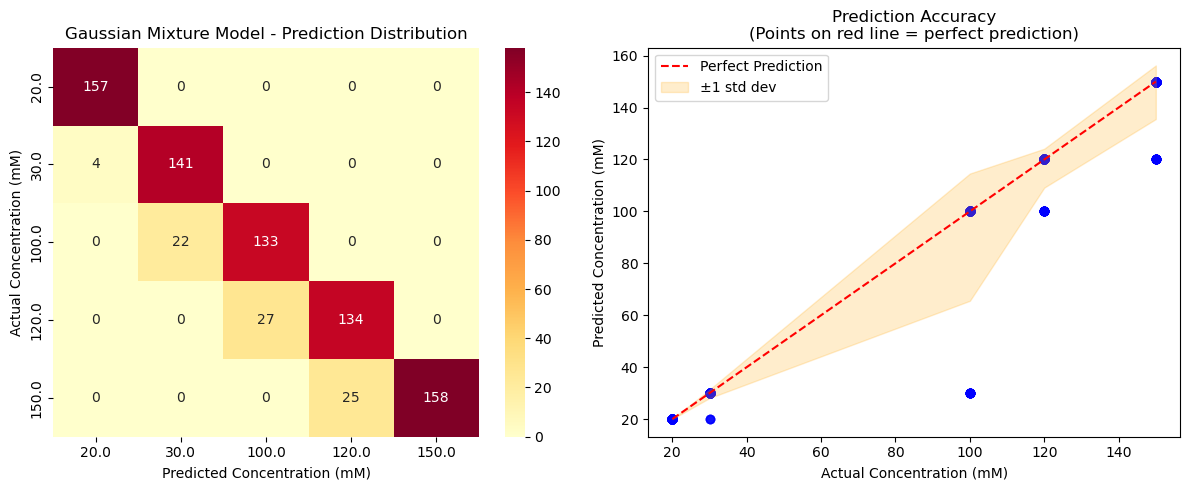

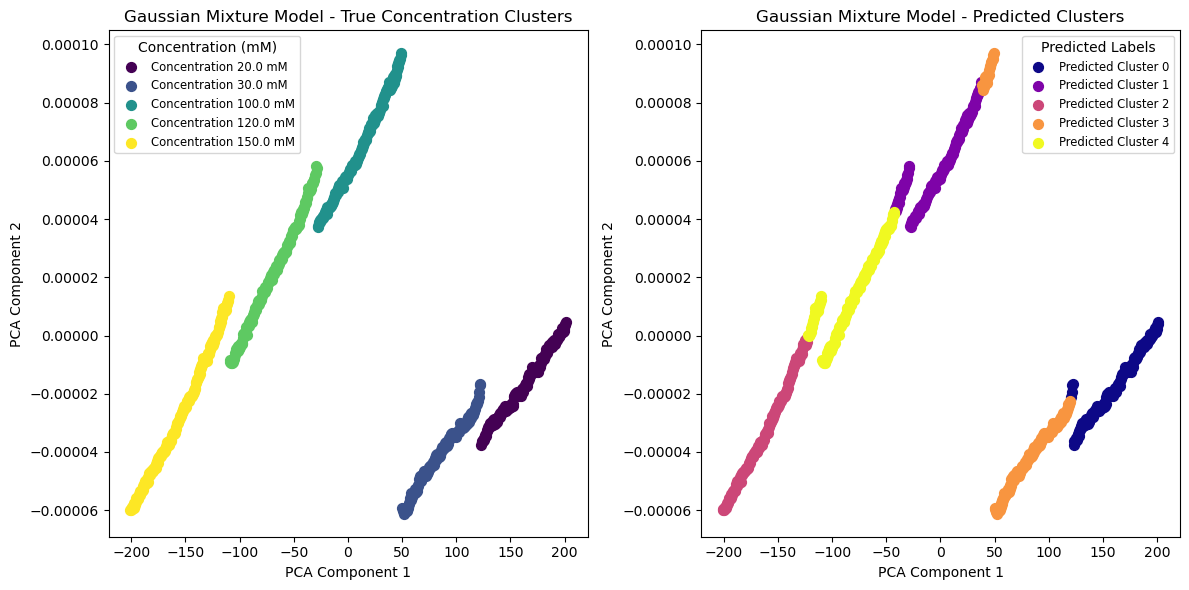

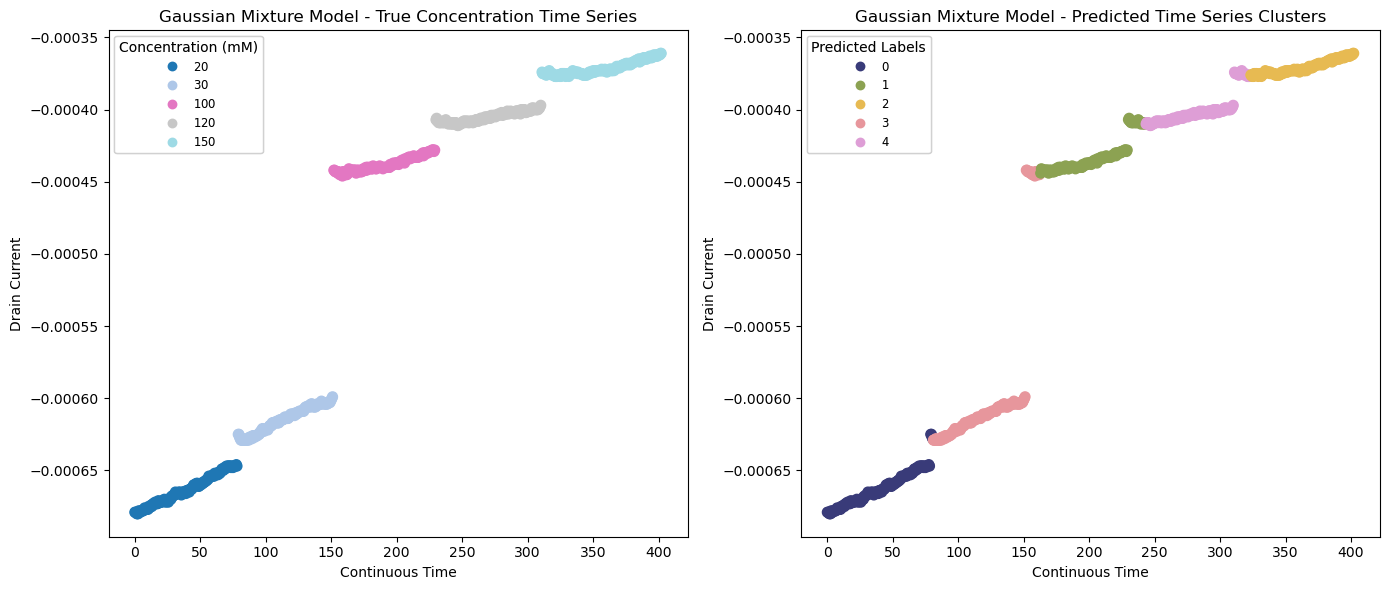

In [31]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Hyperparameter tuning for Gaussian Mixture Model
best_score = -1
best_params = {'n_components': None, 'covariance_type': None}

for n_components in range(n,n+1):
    for covariance_type in ['spherical', 'tied', 'diag', 'full']:
        gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
        labels = gmm.fit_predict(data_for_clustering)
        score = silhouette_score(data_for_clustering, labels)
        if score > best_score:
            best_score = score
            best_params = {'n_components': n_components, 'covariance_type': covariance_type}

print("Best params for Gaussian Mixture Model:", best_params, "with Silhouette Score:", best_score)

# Create the final GMM model with the best parameters
final_gmm = GaussianMixture(n_components=best_params['n_components'], covariance_type=best_params['covariance_type'], random_state=42)
final_gmm_labels = final_gmm.fit_predict(data_for_clustering)

# Evaluate and display results for the final GMM model
evaluate_and_display_results(original_labels, final_gmm_labels, data_for_clustering, "Gaussian Mixture Model")
plot_clusters_pca(data_for_clustering, original_labels, final_gmm_labels, "Gaussian Mixture Model")
plot_time_series_clusters(data, original_labels, final_gmm_labels, "Gaussian Mixture Model")

#### K-Means

Best params for K-Means: {'n_clusters': 5} with Silhouette Score: 0.5602360491679111
Do you want to add noise or not ? (yes/no): no
Concentration 20.0 mM: Time range from 0.0 to 78.0
Concentration 30.0 mM: Time range from 79.0 to 151.0
Concentration 100.0 mM: Time range from 152.0 to 229.0
Concentration 120.0 mM: Time range from 230.0 to 310.0
Concentration 150.0 mM: Time range from 311.0 to 402.0
Metrics for K-Means Clustering:
Adjusted Rand Index (ARI): 0.8437
Silhouette Score: 0.5750



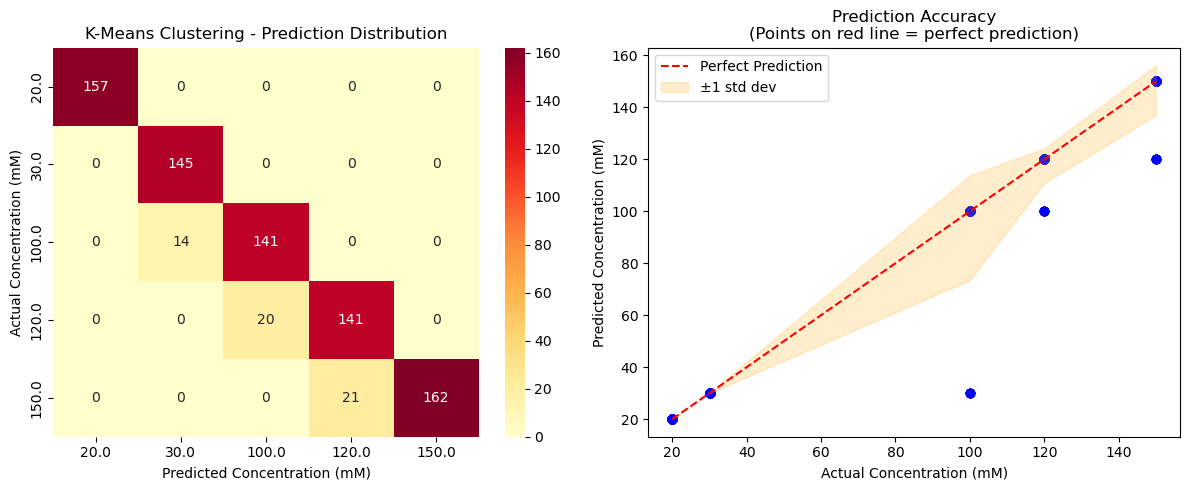

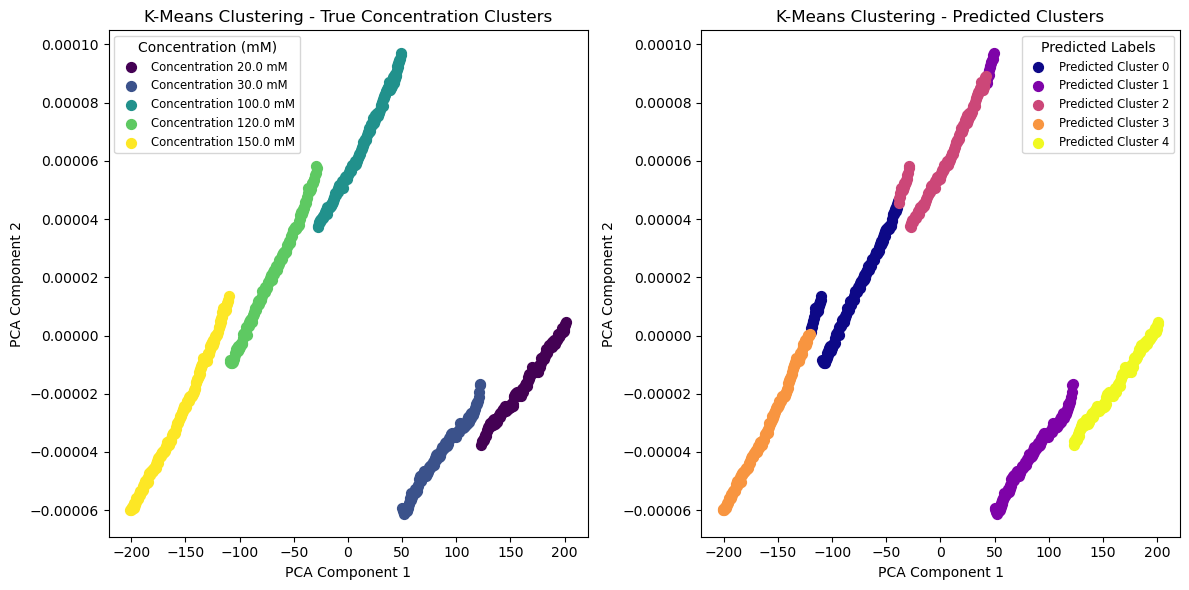

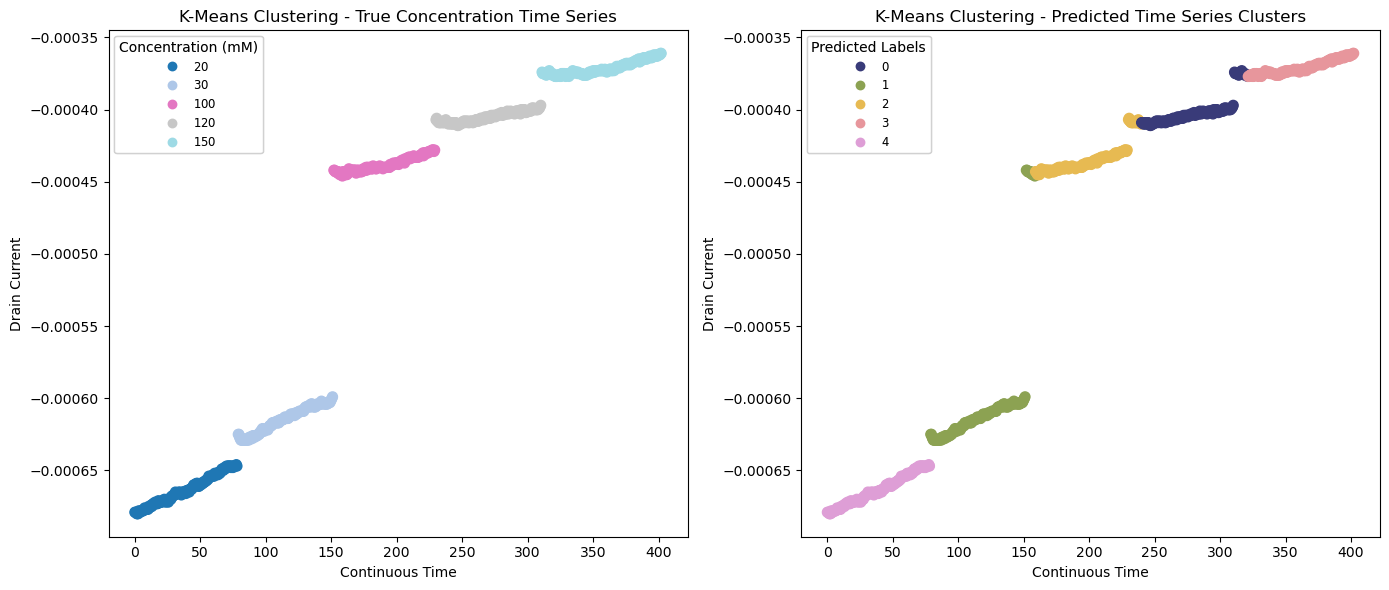

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Hyperparameter tuning for K-Means
best_score_kmeans = -1
best_n_clusters = None

for n_clusters in range(n,n+1):  # Adjust range as needed
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data_for_clustering)
    score = silhouette_score(data_for_clustering, labels)
    if score > best_score_kmeans:
        best_score_kmeans = score
        best_n_clusters = n_clusters

print("Best params for K-Means:", {'n_clusters': best_n_clusters}, "with Silhouette Score:", best_score_kmeans)

# Create the final K-Means model with the best parameters
final_kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
final_kmeans_labels = final_kmeans.fit_predict(data_for_clustering)

# Evaluate and display results for the final K-Means model
evaluate_and_display_results(original_labels, final_kmeans_labels, data_for_clustering, "K-Means Clustering")
plot_clusters_pca(data_for_clustering, original_labels, final_kmeans_labels, "K-Means Clustering")
plot_time_series_clusters(data, original_labels, final_kmeans_labels, "K-Means Clustering")

#### Hierarchical Clustering

Best params for Agglomerative Clustering: (5, 'single') with Silhouette Score: 0.5607571767065199
Do you want to add noise or not ? (yes/no): no
Concentration 20.0 mM: Time range from 0.0 to 78.0
Concentration 30.0 mM: Time range from 79.0 to 151.0
Concentration 100.0 mM: Time range from 152.0 to 229.0
Concentration 120.0 mM: Time range from 230.0 to 310.0
Concentration 150.0 mM: Time range from 311.0 to 402.0
Metrics for Agglomerative Clustering:
Adjusted Rand Index (ARI): 1.0000
Silhouette Score: 0.6220



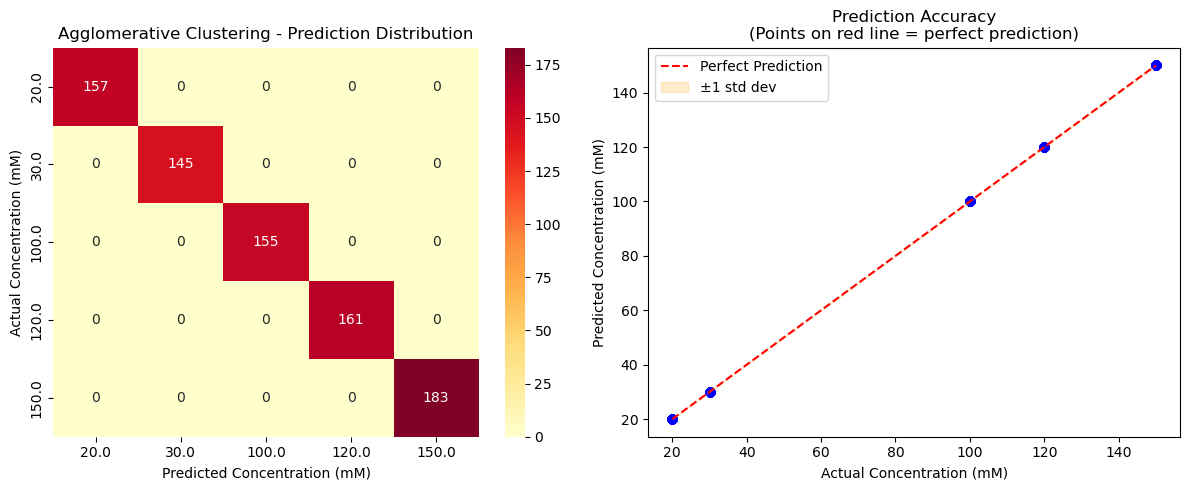

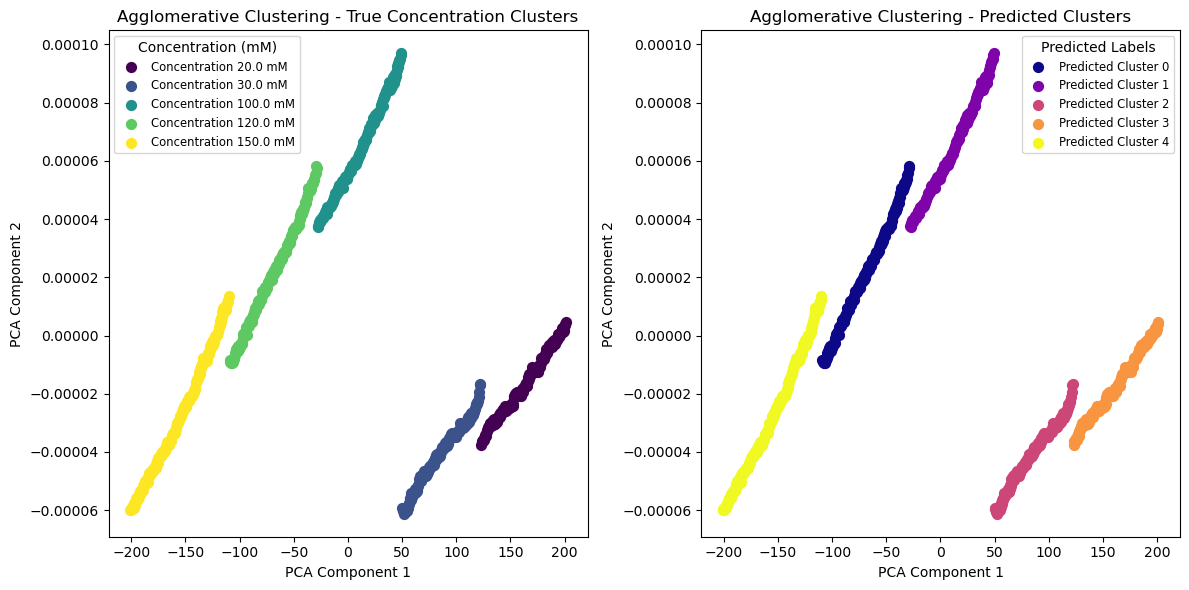

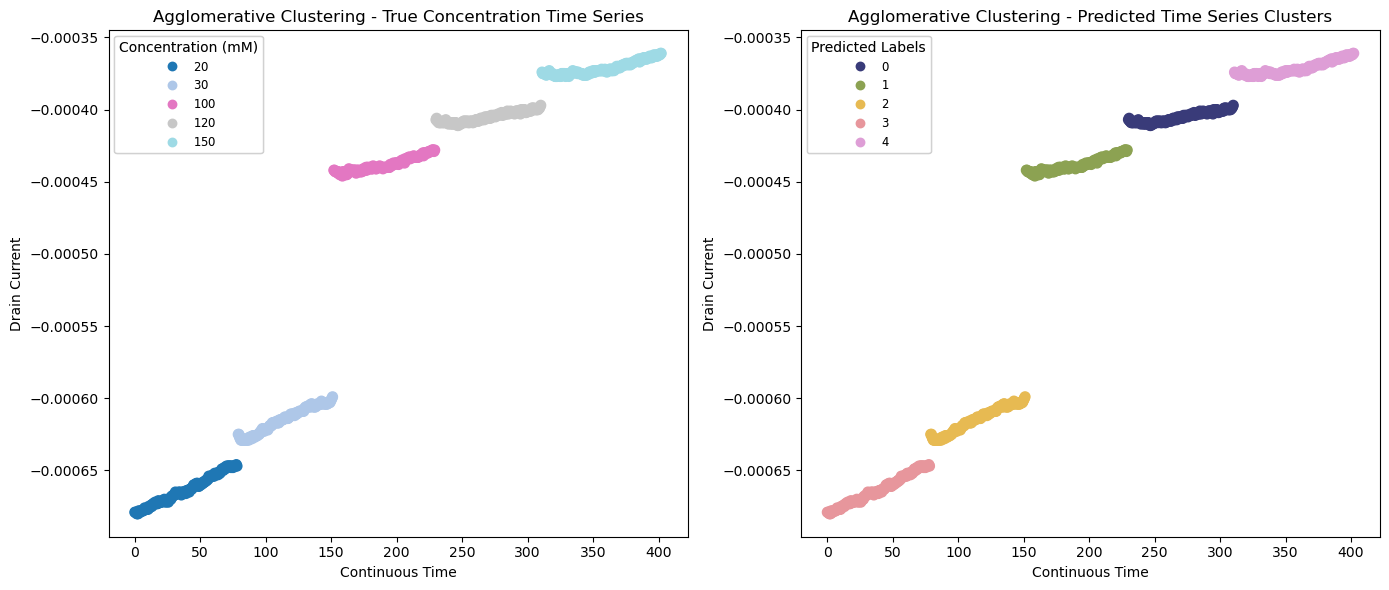

In [33]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

# Initialize variables to track the best score and parameters
best_score = -1
best_params = None

# Fixed number of clusters
n_clusters = n

# Loop through different linkage methods
for linkage in ['single', 'complete', 'average', 'ward']:
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    labels = model.fit_predict(data_for_clustering)

    # Calculate silhouette score, ensuring there are more than one cluster
    if len(set(labels)) > 1:  # Check if more than one cluster exists
        score = silhouette_score(data_for_clustering, labels)
        if score > best_score:
            best_score = score
            best_params = (n_clusters, linkage)

print("Best params for Agglomerative Clustering:", best_params, "with Silhouette Score:", best_score)

# Create the final Agglomerative model with the best parameters
final_hierarchical = AgglomerativeClustering(n_clusters=best_params[0], linkage=best_params[1])
final_hierarchical_labels = final_hierarchical.fit_predict(data_for_clustering)

# Evaluate and display results for the final Agglomerative model
evaluate_and_display_results(original_labels, final_hierarchical_labels, data_for_clustering, "Agglomerative Clustering")
plot_clusters_pca(data_for_clustering, original_labels, final_hierarchical_labels, "Agglomerative Clustering")
plot_time_series_clusters(data, original_labels, final_hierarchical_labels, "Agglomerative Clustering")

#### DBSCAN

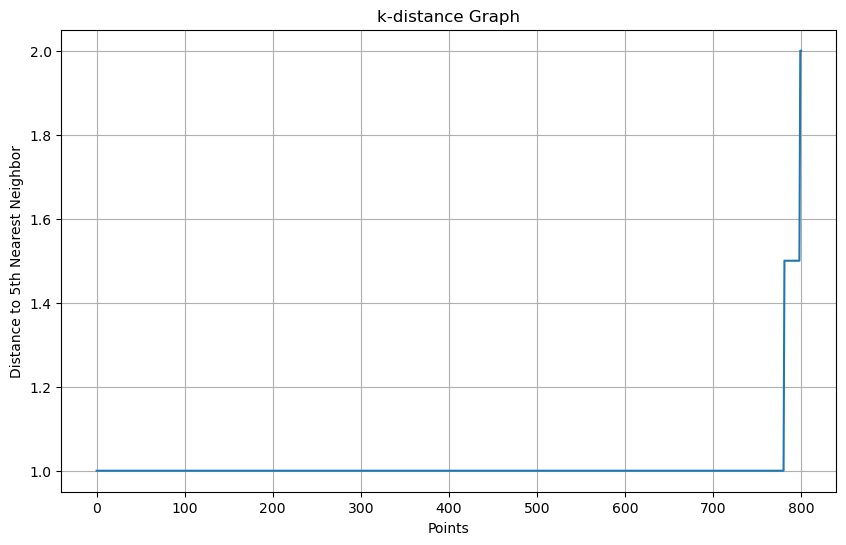

Do you want to add noise or not ? (yes/no): no
Concentration 20.0 mM: Time range from 0.0 to 78.0
Concentration 30.0 mM: Time range from 79.0 to 151.0
Concentration 100.0 mM: Time range from 152.0 to 229.0
Concentration 120.0 mM: Time range from 230.0 to 310.0
Concentration 150.0 mM: Time range from 311.0 to 402.0
Metrics for DBSCAN Clustering:
Adjusted Rand Index (ARI): 1.0000
Silhouette Score: 0.6220



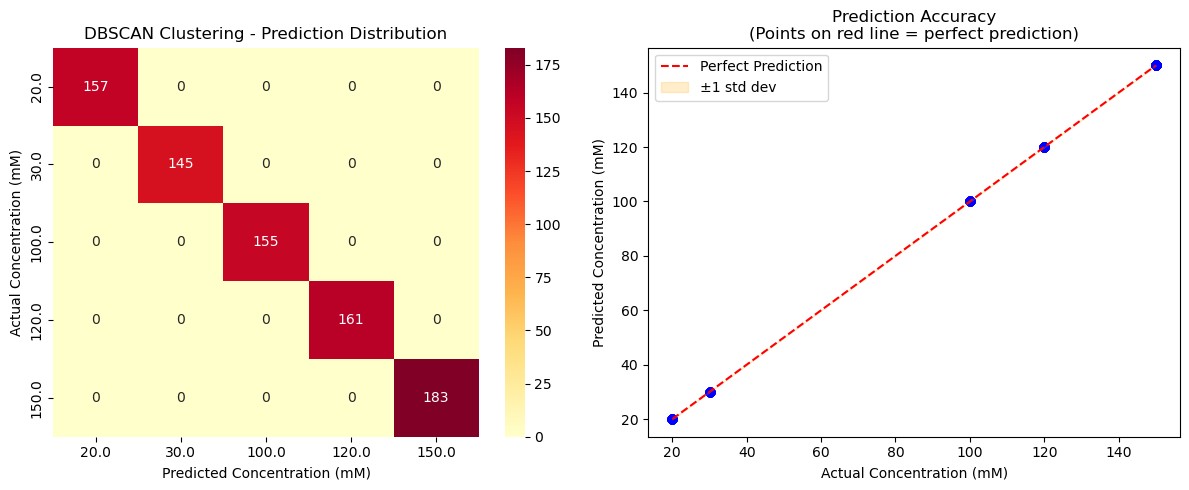

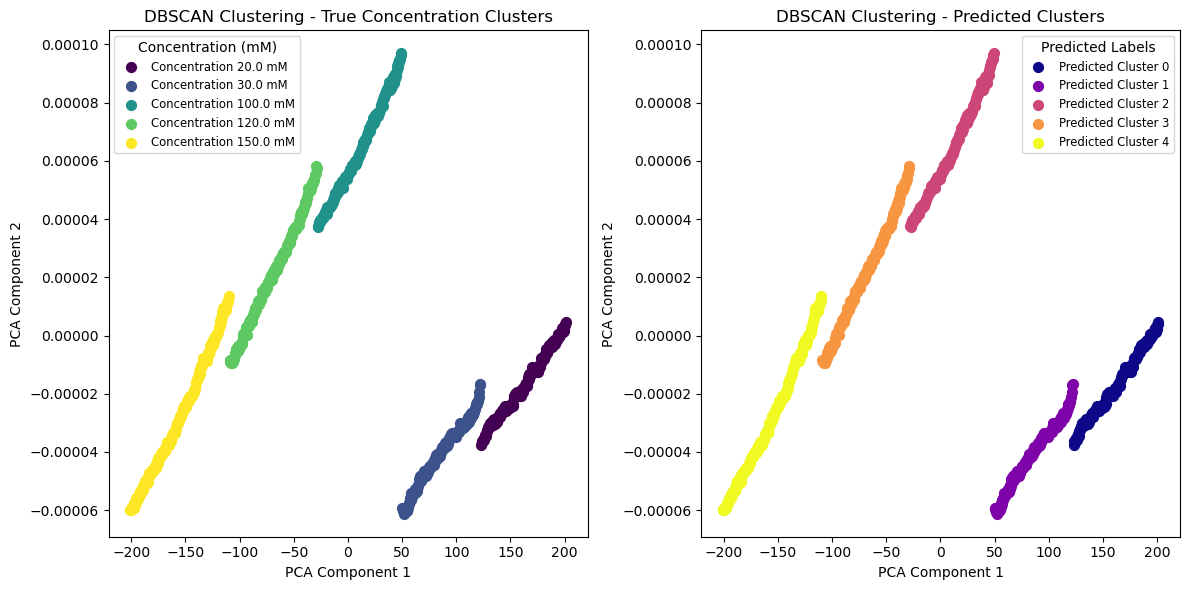

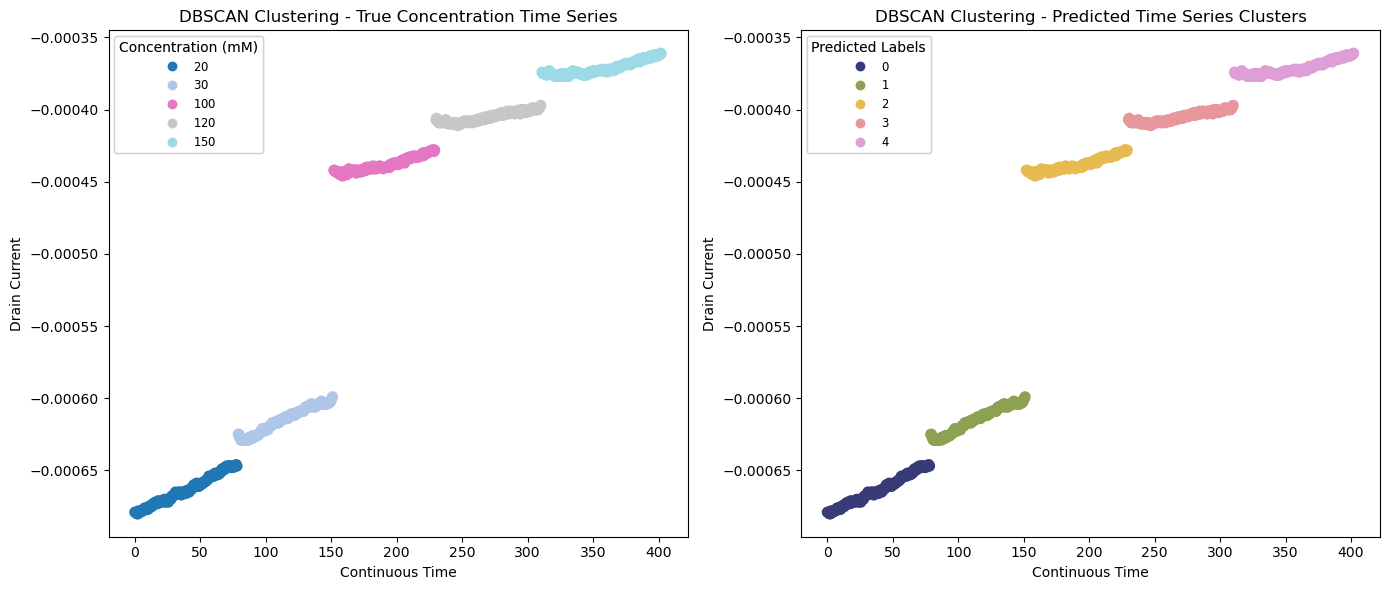

DBSCAN Clustering Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3

In [34]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Plotting k-distance graph to find a good `eps`
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(data_for_clustering)
distances, indices = neighbors_fit.kneighbors(data_for_clustering)
distances = np.sort(distances[:, 4], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('k-distance Graph')
plt.xlabel('Points')
plt.ylabel('Distance to 5th Nearest Neighbor')
plt.grid()
plt.show()

# Use specified parameters for DBSCAN
eps = 1
min_samples = 3

# Create the final DBSCAN model with the specified parameters
final_dbscan = DBSCAN(eps=eps, min_samples=min_samples)
final_dbscan_labels = final_dbscan.fit_predict(data_for_clustering)

# Evaluate and display results for the final DBSCAN model
evaluate_and_display_results(original_labels, final_dbscan_labels, data_for_clustering, "DBSCAN Clustering")
plot_clusters_pca(data_for_clustering, original_labels, final_dbscan_labels, "DBSCAN Clustering")
plot_time_series_clusters(data, original_labels, final_dbscan_labels, "DBSCAN Clustering")

# Print results for reference
print("DBSCAN Clustering Labels:", final_dbscan_labels)

#### Time Series K-means

In [35]:
# Function to plot PCA-reduced clusters
def plot_clusters_pcat(data, original_labels, predicted_labels, model_name):
    # Flatten reshaped data for PCA
    flattened_data = data.reshape(data.shape[0], -1)

    # Perform PCA to reduce dimensions
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(flattened_data)

    # Create a color map for the original labels (concentrations)
    unique_concentrations = np.unique(original_labels)
    concentration_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_concentrations)))

    # Create a color map for the predicted labels (clusters)
    unique_clusters = np.unique(predicted_labels)
    cluster_colors = plt.cm.plasma(np.linspace(0, 1, len(unique_clusters)))

    plt.figure(figsize=(12, 6))

    # Plot True Concentration Clusters
    plt.subplot(1, 2, 1)
    for i, conc in enumerate(unique_concentrations):
        mask = original_labels == conc
        plt.scatter(reduced_data[mask, 0], reduced_data[mask, 1],
                    color=concentration_colors[i], label=f'Concentration {conc} mM', s=50)

    plt.title(f'{model_name} - True Concentration Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')

    # Adjust legend size and position
    plt.legend(title='Concentration (mM)', loc='best', fontsize='small', title_fontsize='medium')

    # Plot Predicted Clusters
    plt.subplot(1, 2, 2)
    for i, cluster_num in enumerate(unique_clusters):
        mask = predicted_labels == cluster_num
        plt.scatter(reduced_data[mask, 0], reduced_data[mask, 1],
                    color=cluster_colors[i], label=f'Predicted Cluster {cluster_num}', s=50)

    plt.title(f'{model_name} - Predicted Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')

    # Adjust legend size and position
    plt.legend(title='Predicted Labels', loc='best', fontsize='small', title_fontsize='medium')

    plt.tight_layout()
    plt.show()


In [36]:
def plot_time_series_clusterst(data_reshaped, continuous_time, drain_current, 
                              true_labels, predicted_labels, model_name):
    """
    Plots time series clusters (Drain Current vs. Time) for true concentrations and predicted clusters.

    Parameters:
    - data_reshaped: Numpy array of shape (n_samples, n_timesteps, n_features), reshaped time series data.
    - continuous_time: 1D Numpy array, corresponding to the continuous time axis.
    - drain_current: 1D Numpy array, corresponding to the drain current values.
    - true_labels: Array-like, true concentration labels.
    - predicted_labels: Array-like, predicted cluster labels.
    - model_name: String, title prefix for the plots.
    """
    # Create a figure with two subplots
    plt.figure(figsize=(14, 6))

    # Plot True Concentration Clusters
    plt.subplot(1, 2, 1)
    scatter1 = plt.scatter(continuous_time, drain_current, c=true_labels, cmap='tab20', s=50, alpha=0.6)
    plt.title(f'{model_name} - True Concentration Clusters')
    plt.xlabel('Continuous Time')
    plt.ylabel('Drain Current')
    plt.legend(*scatter1.legend_elements(), title="Concentration (mM)", loc="best", fontsize="small")
    plt.grid(alpha=0.3)

    # Plot Predicted Clusters
    plt.subplot(1, 2, 2)
    scatter2 = plt.scatter(continuous_time, drain_current, c=predicted_labels, cmap='tab20b', s=50, alpha=0.6)
    plt.title(f'{model_name} - Predicted Clusters')
    plt.xlabel('Continuous Time')
    plt.ylabel('Drain Current')
    plt.legend(*scatter2.legend_elements(), title="Cluster", loc="best", fontsize="small")
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


C:\Users\pujar_rd15uog\anaconda3\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


Do you want to add noise or not ? (yes/no): no
Concentration 20.0 mM: Time range from 0.0 to 78.0
Concentration 30.0 mM: Time range from 79.0 to 151.0
Concentration 100.0 mM: Time range from 152.0 to 229.0
Concentration 120.0 mM: Time range from 230.0 to 310.0
Concentration 150.0 mM: Time range from 311.0 to 402.0
Metrics for Time Series -Euclidean Clustering:
Adjusted Rand Index (ARI): 0.9374
Silhouette Score: 0.6074



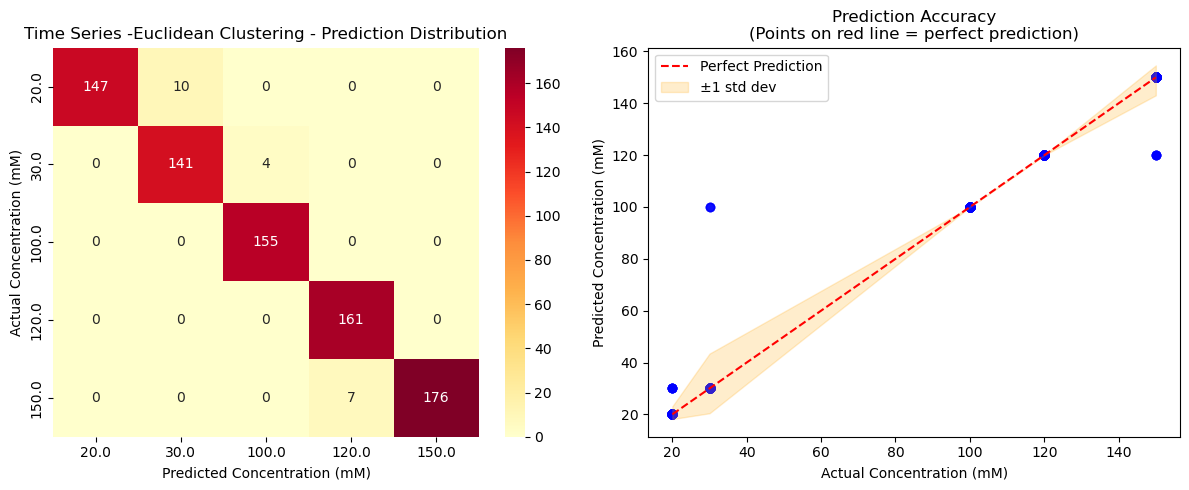

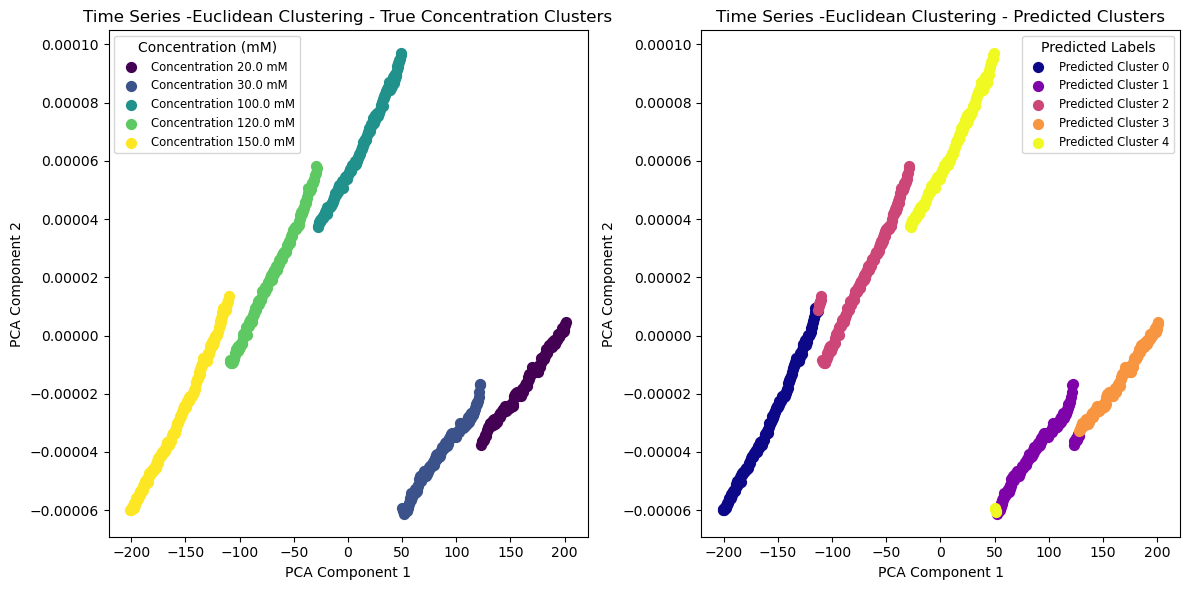

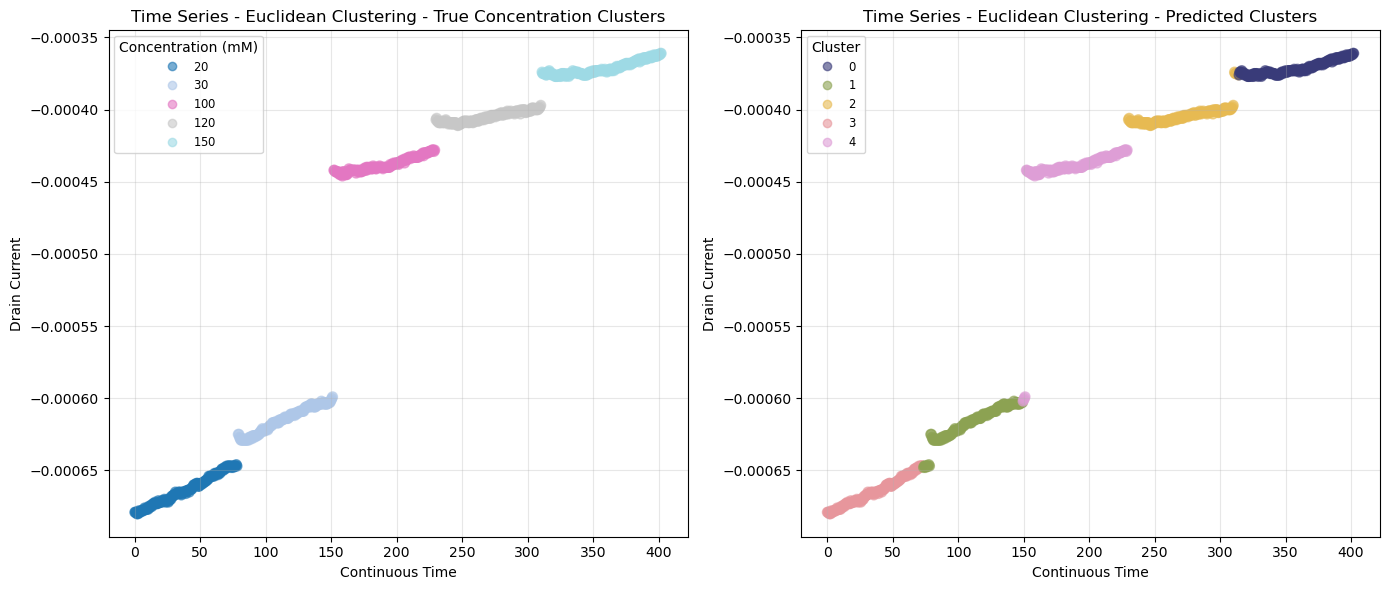

In [37]:
!pip install tslearn
import numpy as np
import pandas as pd
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

data_for_clustering = data.drop(columns=['Concentration (mM)'])
# Step 2: Reshape data for time series clustering
data_for_clustering_reshaped = data_for_clustering.values.reshape(
    data_for_clustering.shape[0], data_for_clustering.shape[1], 1
)
model_euclidean = TimeSeriesKMeans(n_clusters=n, metric="euclidean", max_iter=10, random_state=0)
y_pred_euclidean = model_euclidean.fit_predict(data_for_clustering_reshaped)
# Evaluate and display results for the final euclidean model
evaluate_and_display_results(original_labels,y_pred_euclidean , data_for_clustering_reshaped, "Time Series -Euclidean Clustering")
plot_clusters_pcat(data_for_clustering_reshaped, original_labels,y_pred_euclidean , "Time Series -Euclidean Clustering")
#plot_time_series_clusterst(data_for_clustering_reshaped, original_labels,y_pred_euclidean , "Time Series -Euclidean Clustering")
# Plot Drain Current vs. Time for True and Predicted Clusters
plot_time_series_clusterst(
    data_reshaped=data_for_clustering_reshaped, 
    continuous_time=data['Continuous Time'].values,
    drain_current=data['Drain Current'].values,
    true_labels=original_labels,
    predicted_labels=y_pred_euclidean,
    model_name="Time Series - Euclidean Clustering"
)


Do you want to add noise or not ? (yes/no): no
Concentration 20.0 mM: Time range from 0.0 to 78.0
Concentration 30.0 mM: Time range from 79.0 to 151.0
Concentration 100.0 mM: Time range from 152.0 to 229.0
Concentration 120.0 mM: Time range from 230.0 to 310.0
Concentration 150.0 mM: Time range from 311.0 to 402.0
Metrics for Time Series -dtw Clustering:
Adjusted Rand Index (ARI): 0.9374
Silhouette Score: 0.6074



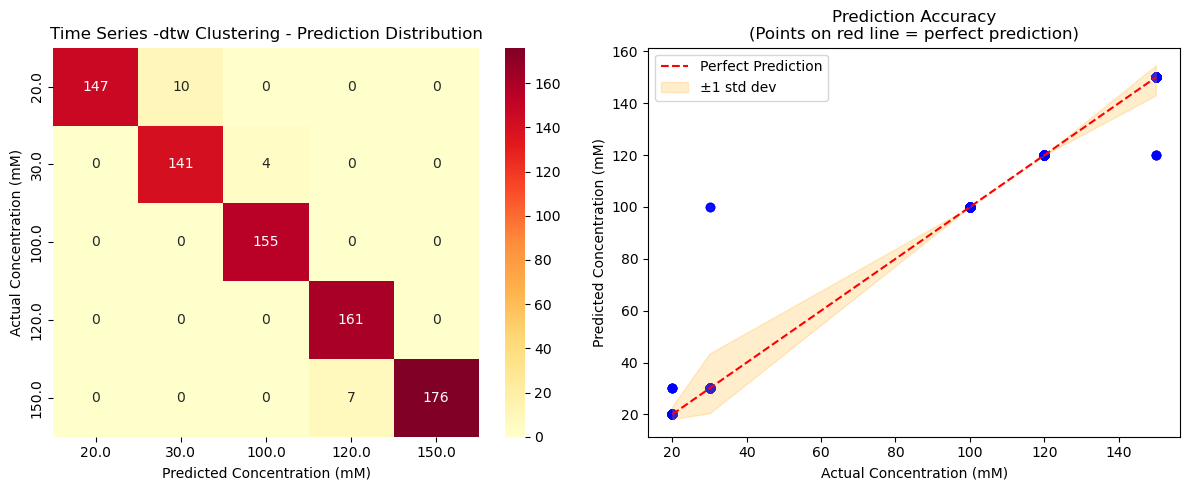

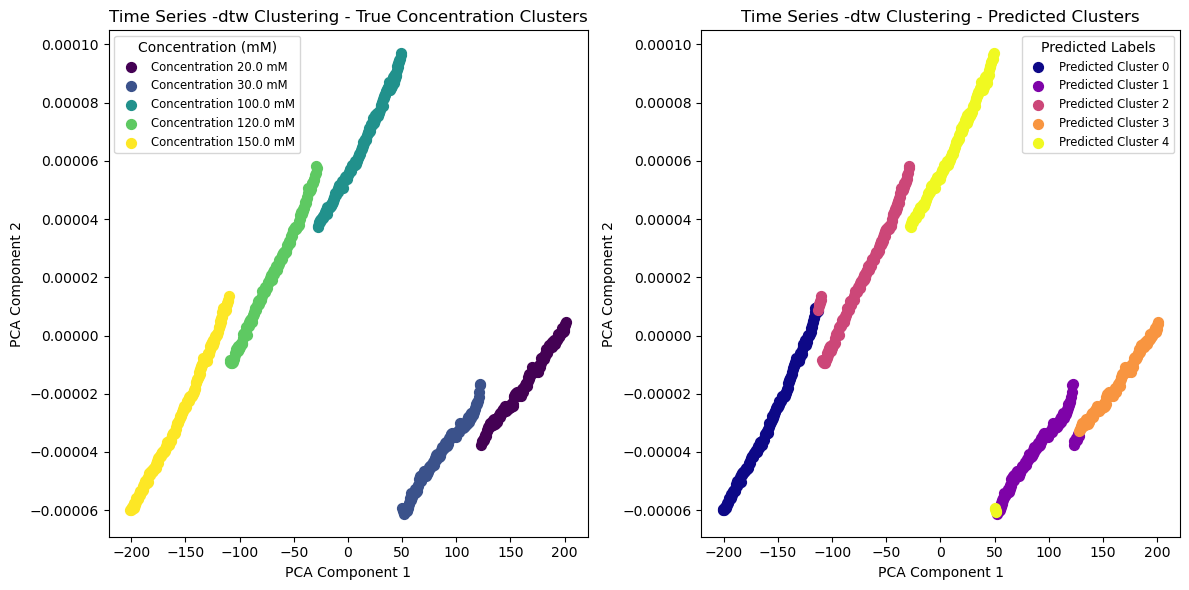

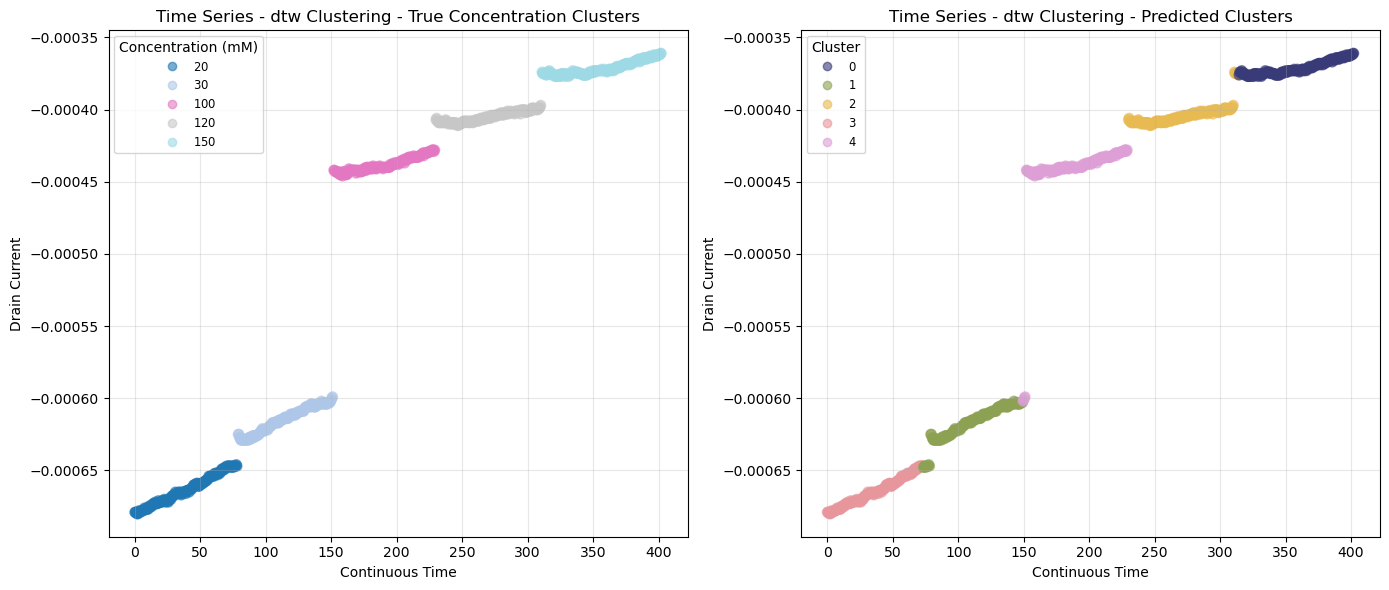

In [38]:

import numpy as np
import pandas as pd
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

model_dtw = TimeSeriesKMeans(n_clusters=n, metric="dtw", max_iter=10, random_state=0)
y_pred_dtw = model_dtw.fit_predict(data_for_clustering_reshaped)
# Evaluate and display results for the final dtw model
evaluate_and_display_results(original_labels,y_pred_dtw, data_for_clustering_reshaped, "Time Series -dtw Clustering")
plot_clusters_pcat(data_for_clustering_reshaped, original_labels,y_pred_dtw, "Time Series -dtw Clustering")
#plot_time_series_clusterst(data_for_clustering_reshaped, original_labels,y_pred_dtw , "Time Series -dtw Clustering")
# Plot Drain Current vs. Time for True and Predicted Clusters
plot_time_series_clusterst(
    data_reshaped=data_for_clustering_reshaped, 
    continuous_time=data['Continuous Time'].values,
    drain_current=data['Drain Current'].values,
    true_labels=original_labels,
    predicted_labels=y_pred_dtw,
    model_name="Time Series - dtw Clustering"
)


Do you want to add noise or not ? (yes/no): no
Concentration 20.0 mM: Time range from 0.0 to 78.0
Concentration 30.0 mM: Time range from 79.0 to 151.0
Concentration 100.0 mM: Time range from 152.0 to 229.0
Concentration 120.0 mM: Time range from 230.0 to 310.0
Concentration 150.0 mM: Time range from 311.0 to 402.0
Metrics for Time Series -softdtw Clustering:
Adjusted Rand Index (ARI): 0.7873
Silhouette Score: 0.5591



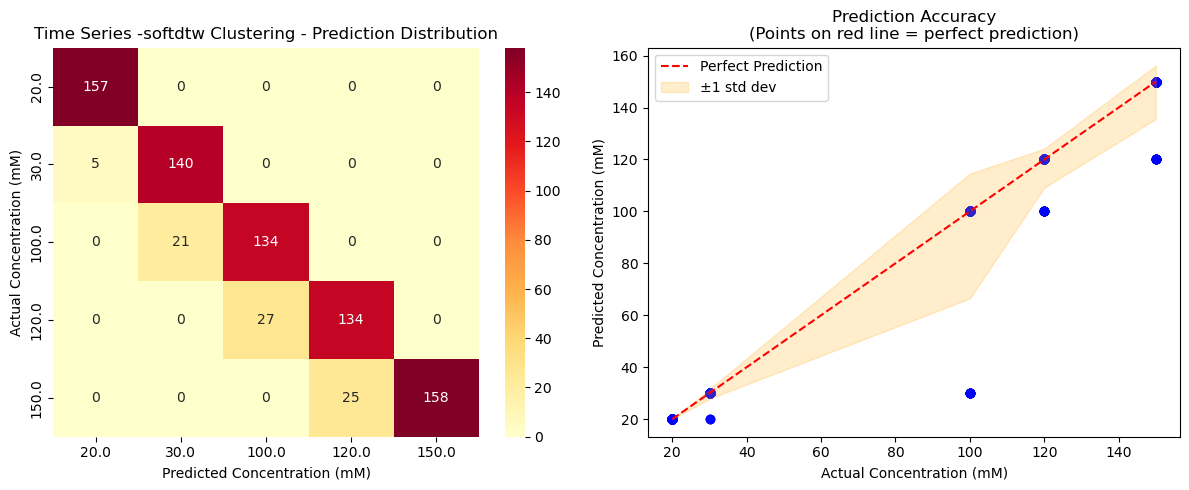

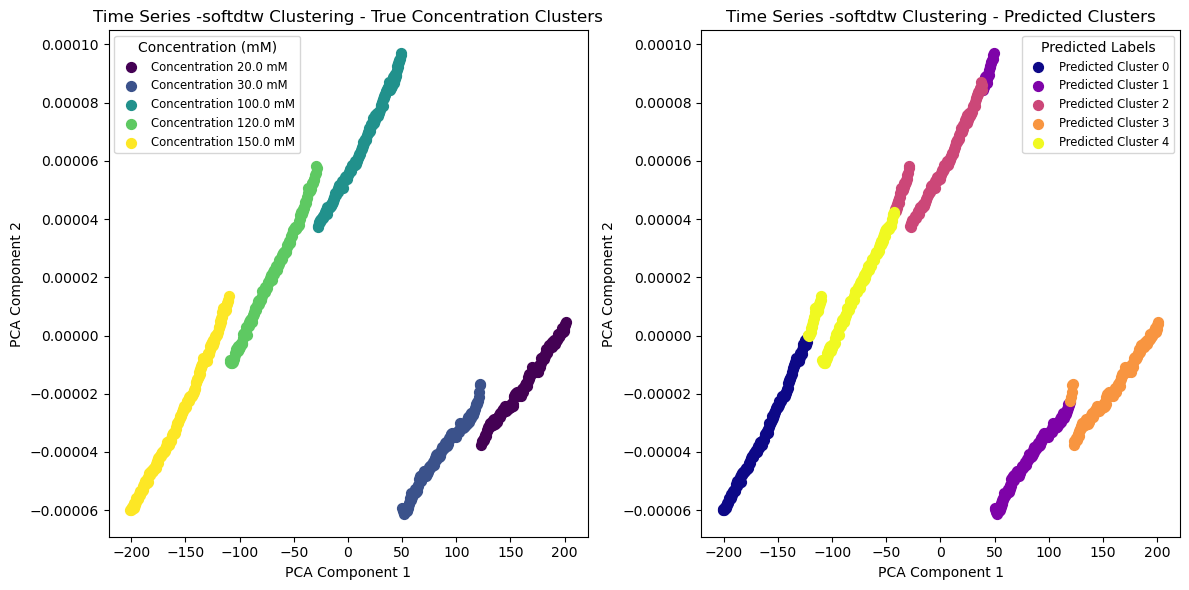

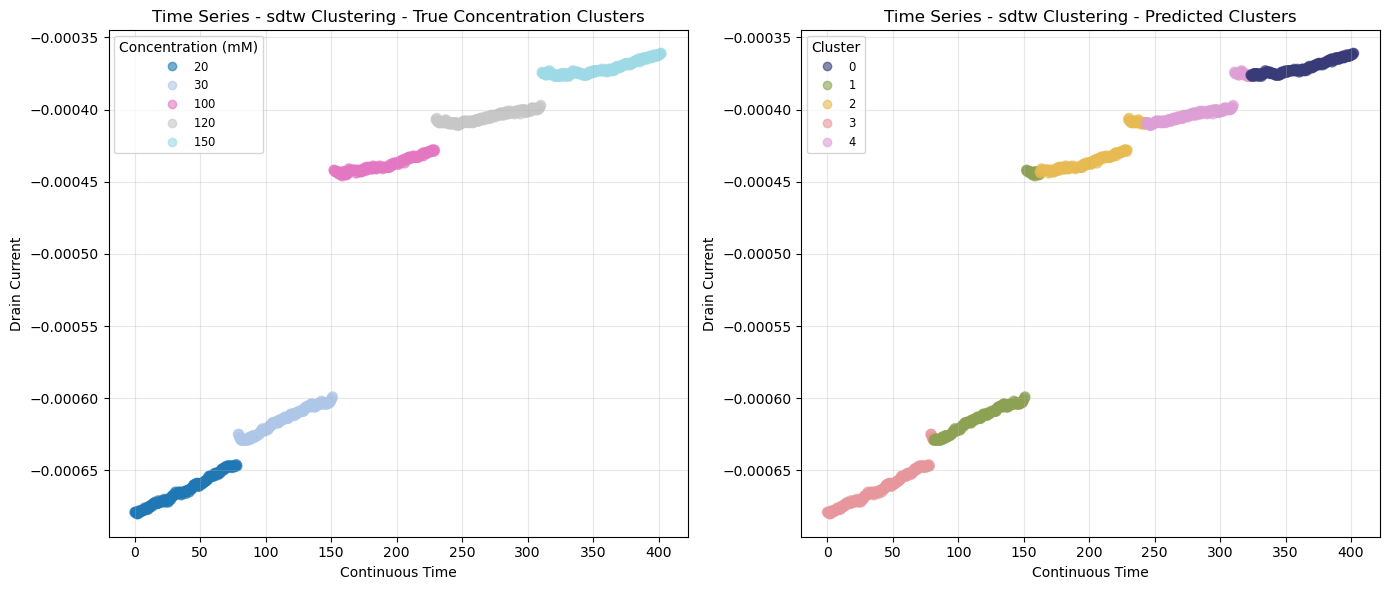

In [39]:

import numpy as np
import pandas as pd
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


model_sdtw = TimeSeriesKMeans(n_clusters=n, metric="softdtw", max_iter=10, random_state=0)
y_pred_sdtw = model_sdtw.fit_predict(data_for_clustering_reshaped)
# Evaluate and display results for the final DBSCAN model
evaluate_and_display_results(original_labels,y_pred_sdtw,data_for_clustering_reshaped ,"Time Series -softdtw Clustering")
plot_clusters_pcat(data_for_clustering_reshaped, original_labels,y_pred_sdtw, "Time Series -softdtw Clustering")
#plot_time_series_clusterst(data_for_clustering_reshaped, original_labels,y_pred_sdtw, "Time Series -softdtw Clustering")
# Plot Drain Current vs. Time for True and Predicted Clusters
plot_time_series_clusterst(
    data_reshaped=data_for_clustering_reshaped, 
    continuous_time=data['Continuous Time'].values,
    drain_current=data['Drain Current'].values,
    true_labels=original_labels,
    predicted_labels=y_pred_sdtw,
    model_name="Time Series - sdtw Clustering"
)


#### LSTM

In [40]:
import numpy as np
import tensorflow as tf
import random

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


Do you want to add noise or not ? (yes/no): no
Concentration 20.0 mM: Time range from 0.0 to 78.0
Concentration 30.0 mM: Time range from 79.0 to 151.0
Concentration 100.0 mM: Time range from 152.0 to 229.0
Concentration 120.0 mM: Time range from 230.0 to 310.0
Concentration 150.0 mM: Time range from 311.0 to 402.0


C:\Users\pujar_rd15uog\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.2295 - loss: 1.5935 - val_accuracy: 0.4293 - val_loss: 1.5142
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3678 - loss: 1.4583 - val_accuracy: 0.4949 - val_loss: 1.2537
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5412 - loss: 1.1803 - val_accuracy: 0.7677 - val_loss: 0.9058
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7804 - loss: 0.8755 - val_accuracy: 0.8283 - val_loss: 0.7510
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8297 - loss: 0.7214 - val_accuracy: 0.9495 - val_loss: 0.4787
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8641 - loss: 0.5764 - val_accuracy: 0.8737 - val_loss: 0.4075
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8840 - loss: 0.3967 - val_accuracy: 0.8838 - val_loss: 0.2912
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9189 - loss: 0.2753 - val_accuracy: 0.9091 - val_lo

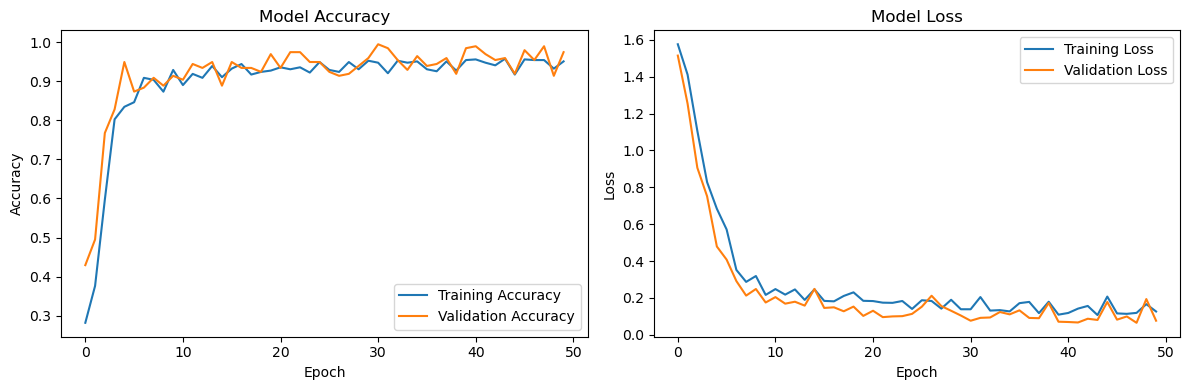

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


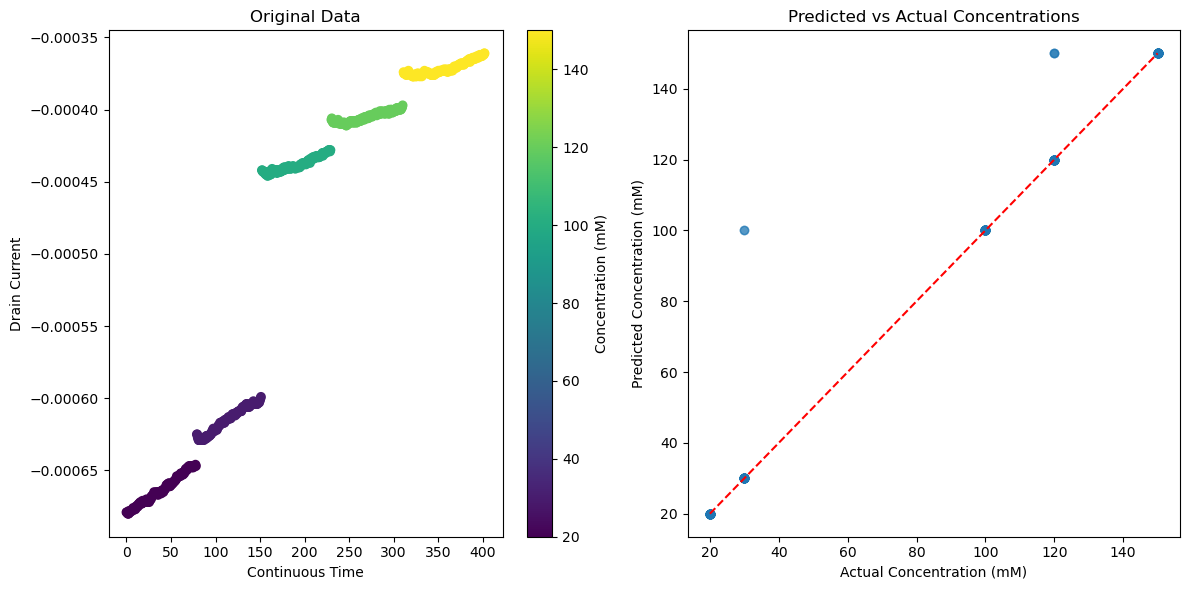


Test Accuracy: 0.9747


In [41]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def prepare_sequences(data, seq_length):
    """
    Prepare sequences for LSTM input
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def create_lstm_model(seq_length, n_features, n_classes):
    """
    Create LSTM model for classification
    """
    model = Sequential([
        LSTM(64, input_shape=(seq_length, n_features), return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    return model

# Prepare the data
def prepare_data(data, seq_length=10):
    # Extract features and target
    X = data[['Continuous Time', 'Drain Current']].values
    y = data['Concentration (mM)'].values
    
    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Prepare sequences
    X_seq, y_seq = prepare_sequences(X_scaled, seq_length)
    
    # Convert target to categorical
    unique_concentrations = np.unique(y)
    y_categorical = np.zeros((len(y_seq), len(unique_concentrations)))
    for i, conc in enumerate(y[seq_length:]):
        y_categorical[i, np.where(unique_concentrations == conc)[0]] = 1
    
    return X_seq, y_categorical, scaler, unique_concentrations

def train_lstm_model(X_seq, y_categorical):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_seq, y_categorical, test_size=0.25, random_state=42
    )
    
    # Create and compile the model
    model = create_lstm_model(
        seq_length=X_seq.shape[1],
        n_features=X_seq.shape[2],
        n_classes=y_categorical.shape[1]
    )
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1
    )
    
    return model, history, (X_train, X_test, y_train, y_test)

def plot_training_history(history):
    """
    Plot training history
    """
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_predictions(model, X_test, y_test, scaler, unique_concentrations, denoised_data):
    """
    Plot actual vs predicted concentrations
    """
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_classes = unique_concentrations[np.argmax(y_pred, axis=1)]
    y_true_classes = unique_concentrations[np.argmax(y_test, axis=1)]
    
    # Plot results
    plt.figure(figsize=(12, 6))
    
    # Original data
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(denoised_data['Continuous Time'], 
                         denoised_data['Drain Current'],
                         c=denoised_data['Concentration (mM)'],
                         cmap='viridis')
    plt.colorbar(scatter, label='Concentration (mM)')
    plt.title('Original Data')
    plt.xlabel('Continuous Time')
    plt.ylabel('Drain Current')
    
    # Predicted vs Actual
    plt.subplot(1, 2, 2)
    plt.scatter(y_true_classes, y_pred_classes, alpha=0.5)
    plt.plot([min(y_true_classes), max(y_true_classes)], 
             [min(y_true_classes), max(y_true_classes)], 
             'r--')
    plt.title('Predicted vs Actual Concentrations')
    plt.xlabel('Actual Concentration (mM)')
    plt.ylabel('Predicted Concentration (mM)')
    
    plt.tight_layout()
    plt.show()

# Main execution
# Prepare the data
seq_length = 10
data = data_create(df)
X_seq, y_categorical, scaler, unique_concentrations = prepare_data(data, seq_length)

# Train the model
model, history, (X_train, X_test, y_train, y_test) = train_lstm_model(X_seq, y_categorical)

# Plot results
plot_training_history(history)
plot_predictions(model, X_test, y_test, scaler, unique_concentrations, data)

# Calculate and print accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

In [42]:
def plot_enhanced_predictions(model, X_test, y_test, scaler, unique_concentrations, denoised_data):
    """
    Create enhanced visualizations for LSTM predictions comparing test data only
    """
    # Get predictions for test data
    y_pred = model.predict(X_test)
    y_pred_classes = unique_concentrations[np.argmax(y_pred, axis=1)]
    y_true_classes = unique_concentrations[np.argmax(y_test, axis=1)]

    # Get the last time point from each sequence for plotting
    X_test_reshaped = X_test.reshape(-1, X_test.shape[2])
    X_test_orig = scaler.inverse_transform(X_test_reshaped)

    # Take every sequence_length points to match with predictions
    test_times = X_test_orig[X_test.shape[1]-1::X_test.shape[1], 0]
    test_currents = X_test_orig[X_test.shape[1]-1::X_test.shape[1], 1]

    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))

    # 1. Test Data: Current vs Time with True Concentrations
    plt.subplot(2, 2, 1)
    plt.scatter(test_times, 
                test_currents,
                c=y_true_classes,
                cmap='tab20')
    plt.title('Test Data: Current vs Time (True Values)')
    plt.xlabel('Continuous Time')
    plt.ylabel('Drain Current')
    legend1_labels = [f'{concentration} mM' for concentration in np.unique(y_true_classes)]
    handles1 = [plt.Line2D([], [], marker='o', color=plt.cm.tab20(1. * i / len(legend1_labels)), linestyle='', label=label) 
                for i, label in enumerate(legend1_labels)]
    plt.legend(handles=handles1, title='True Concentration')

    # 2. Test Data: Current vs Time with Predicted Clusters
    plt.subplot(2, 2, 2)
    plt.scatter(test_times, 
                test_currents,
                c=y_pred_classes,
                cmap='tab20b')
    plt.title('Test Data: Current vs Time (Predicted Values)')
    plt.xlabel('Continuous Time')
    plt.ylabel('Drain Current')
    legend2_labels = [f'{concentration} mM' for concentration in np.unique(y_pred_classes)]
    handles2 = [plt.Line2D([], [], marker='o', color=plt.cm.tab20b(1. * i / len(legend2_labels)), linestyle='', label=label) 
                for i, label in enumerate(legend2_labels)]
    plt.legend(handles=handles2, title='Predicted Clusters')

    # Ensure both plots have the same axis limits
    time_min, time_max = min(test_times), max(test_times)
    current_min, current_max = min(test_currents), max(test_currents)

    for ax in plt.gcf().get_axes()[:2]:  # Only apply to first two subplots
        ax.set_xlim(time_min, time_max)
        ax.set_ylim(current_min, current_max)

    # 3. Confusion Matrix-style Plot
    plt.subplot(2, 2, 3)
    confusion_data = pd.DataFrame({
        'Actual': y_true_classes,
        'Predicted': y_pred_classes
    })
    confusion_counts = confusion_data.groupby(['Actual', 'Predicted']).size().unstack(fill_value=0)
    sns.heatmap(confusion_counts, annot=True, fmt='d', cmap='YlOrRd')
    plt.title('Prediction Distribution Matrix')
    plt.xlabel('Predicted Concentration (mM)')
    plt.ylabel('Actual Concentration (mM)')

    # 4. Prediction Accuracy Plot
    plt.subplot(2, 2, 4)
    plt.scatter(y_true_classes, y_pred_classes, alpha=0.5)
    plt.plot([min(y_true_classes), max(y_true_classes)], 
             [min(y_true_classes), max(y_true_classes)], 
             'r--', label='Perfect Prediction')

    # Calculate and plot error bands
    mean_pred = pd.DataFrame({
        'true': y_true_classes,
        'pred': y_pred_classes
    }).groupby('true')['pred'].agg(['mean', 'std']).reset_index()

    plt.fill_between(mean_pred['true'],
                     mean_pred['mean'] - mean_pred['std'],
                     mean_pred['mean'] + mean_pred['std'],
                     alpha=0.2, color='gray', label='±1 std dev')

    plt.title('Prediction Accuracy\n(Points on red line = perfect prediction)')
    plt.xlabel('Actual Concentration (mM)')
    plt.ylabel('Predicted Concentration (mM)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print accuracy metrics
    correct_predictions = np.sum(y_pred_classes == y_true_classes)
    total_predictions = len(y_pred_classes)
    accuracy = correct_predictions / total_predictions

    print("\nTest Data Analysis:")
    print(f"Total Test Samples: {total_predictions}")
    print(f"Correct Predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy:.2%}")

    # Calculate and print prediction errors
    errors = abs(y_pred_classes - y_true_classes)
    print(f"\nPrediction Error Statistics:")
    print(f"Mean Absolute Error: {np.mean(errors):.2f} mM")
    print(f"Max Error: {np.max(errors):.2f} mM")
    print(f"Standard Deviation of Error: {np.std(errors):.2f} mM")

    # Print shape information for debugging
    print("\nShape Information:")
    print(f"X_test shape: {X_test.shape}")
    print(f"Number of predictions: {len(y_pred_classes)}")
    print(f"Number of plot points: {len(test_times)}")


In [43]:
def plot_enhanced_predictions(model, X_test, y_test, scaler, unique_concentrations, denoised_data):
    """
    Create enhanced visualizations for LSTM predictions comparing test data only
    """
    # Get predictions for test data
    y_pred = model.predict(X_test)
    y_pred_classes = unique_concentrations[np.argmax(y_pred, axis=1)]
    y_true_classes = unique_concentrations[np.argmax(y_test, axis=1)]

    # Get the last time point from each sequence for plotting
    X_test_reshaped = X_test.reshape(-1, X_test.shape[2])
    X_test_orig = scaler.inverse_transform(X_test_reshaped)

    # Take every sequence_length points to match with predictions
    test_times = X_test_orig[X_test.shape[1]-1::X_test.shape[1], 0]
    test_currents = X_test_orig[X_test.shape[1]-1::X_test.shape[1], 1]

    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))

    # 1. Test Data: Current vs Time with True Concentrations
    plt.subplot(2, 2, 1)
    plt.scatter(test_times, 
                test_currents,
                c=y_true_classes,
                cmap='tab20')
    plt.title('Test Data: Current vs Time (True Values)')
    plt.xlabel('Continuous Time')
    plt.ylabel('Drain Current')
    legend1_labels = [f'{concentration} mM' for concentration in np.unique(y_true_classes)]
    handles1 = [plt.Line2D([], [], marker='o', color=plt.cm.tab20(1. * i / len(legend1_labels)), linestyle='', label=label) 
                for i, label in enumerate(legend1_labels)]
    plt.legend(handles=handles1, title='True Concentration')

    # 2. Test Data: Current vs Time with Predicted Clusters
    plt.subplot(2, 2, 2)
    plt.scatter(test_times, 
                test_currents,
                c=y_pred_classes,
                cmap='tab20b')
    plt.title('Test Data: Current vs Time (Predicted Values)')
    plt.xlabel('Continuous Time')
    plt.ylabel('Drain Current')
    legend2_labels = [f'{concentration} mM' for concentration in np.unique(y_pred_classes)]
    handles2 = [plt.Line2D([], [], marker='o', color=plt.cm.tab20b(1. * i / len(legend2_labels)), linestyle='', label=label) 
                for i, label in enumerate(legend2_labels)]
    plt.legend(handles=handles2, title='Predicted Clusters')

    # Ensure both plots have the same axis limits
    time_min, time_max = min(test_times), max(test_times)
    current_min, current_max = min(test_currents), max(test_currents)

    for ax in plt.gcf().get_axes()[:2]:  # Only apply to first two subplots
        ax.set_xlim(time_min, time_max)
        ax.set_ylim(current_min, current_max)

    # 3. Confusion Matrix-style Plot
    plt.subplot(2, 2, 3)
    confusion_data = pd.DataFrame({
        'Actual': y_true_classes,
        'Predicted': y_pred_classes
    })
    confusion_counts = confusion_data.groupby(['Actual', 'Predicted']).size().unstack(fill_value=0)
    sns.heatmap(confusion_counts, annot=True, fmt='d', cmap='YlOrRd')
    plt.title('Prediction Distribution Matrix')
    plt.xlabel('Predicted Concentration (mM)')
    plt.ylabel('Actual Concentration (mM)')

    # 4. Prediction Accuracy Plot
    plt.subplot(2, 2, 4)
    plt.scatter(y_true_classes, y_pred_classes, alpha=0.5)
    plt.plot([min(y_true_classes), max(y_true_classes)], 
             [min(y_true_classes), max(y_true_classes)], 
             'r--', label='Perfect Prediction')

    # Calculate and plot error bands
    mean_pred = pd.DataFrame({
        'true': y_true_classes,
        'pred': y_pred_classes
    }).groupby('true')['pred'].agg(['mean', 'std']).reset_index()

    plt.fill_between(mean_pred['true'],
                     mean_pred['mean'] - mean_pred['std'],
                     mean_pred['mean'] + mean_pred['std'],
                     alpha=0.2, color='gray', label='±1 std dev')

    plt.title('Prediction Accuracy\n(Points on red line = perfect prediction)')
    plt.xlabel('Actual Concentration (mM)')
    plt.ylabel('Predicted Concentration (mM)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print accuracy metrics
    correct_predictions = np.sum(y_pred_classes == y_true_classes)
    total_predictions = len(y_pred_classes)
    accuracy = correct_predictions / total_predictions

    print("\nTest Data Analysis:")
    print(f"Total Test Samples: {total_predictions}")
    print(f"Correct Predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy:.2%}")

    # Calculate and print prediction errors
    errors = abs(y_pred_classes - y_true_classes)
    print(f"\nPrediction Error Statistics:")
    print(f"Mean Absolute Error: {np.mean(errors):.2f} mM")
    print(f"Max Error: {np.max(errors):.2f} mM")
    print(f"Standard Deviation of Error: {np.std(errors):.2f} mM")

    # Print shape information for debugging
    print("\nShape Information:")
    print(f"X_test shape: {X_test.shape}")
    print(f"Number of predictions: {len(y_pred_classes)}")
    print(f"Number of plot points: {len(test_times)}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


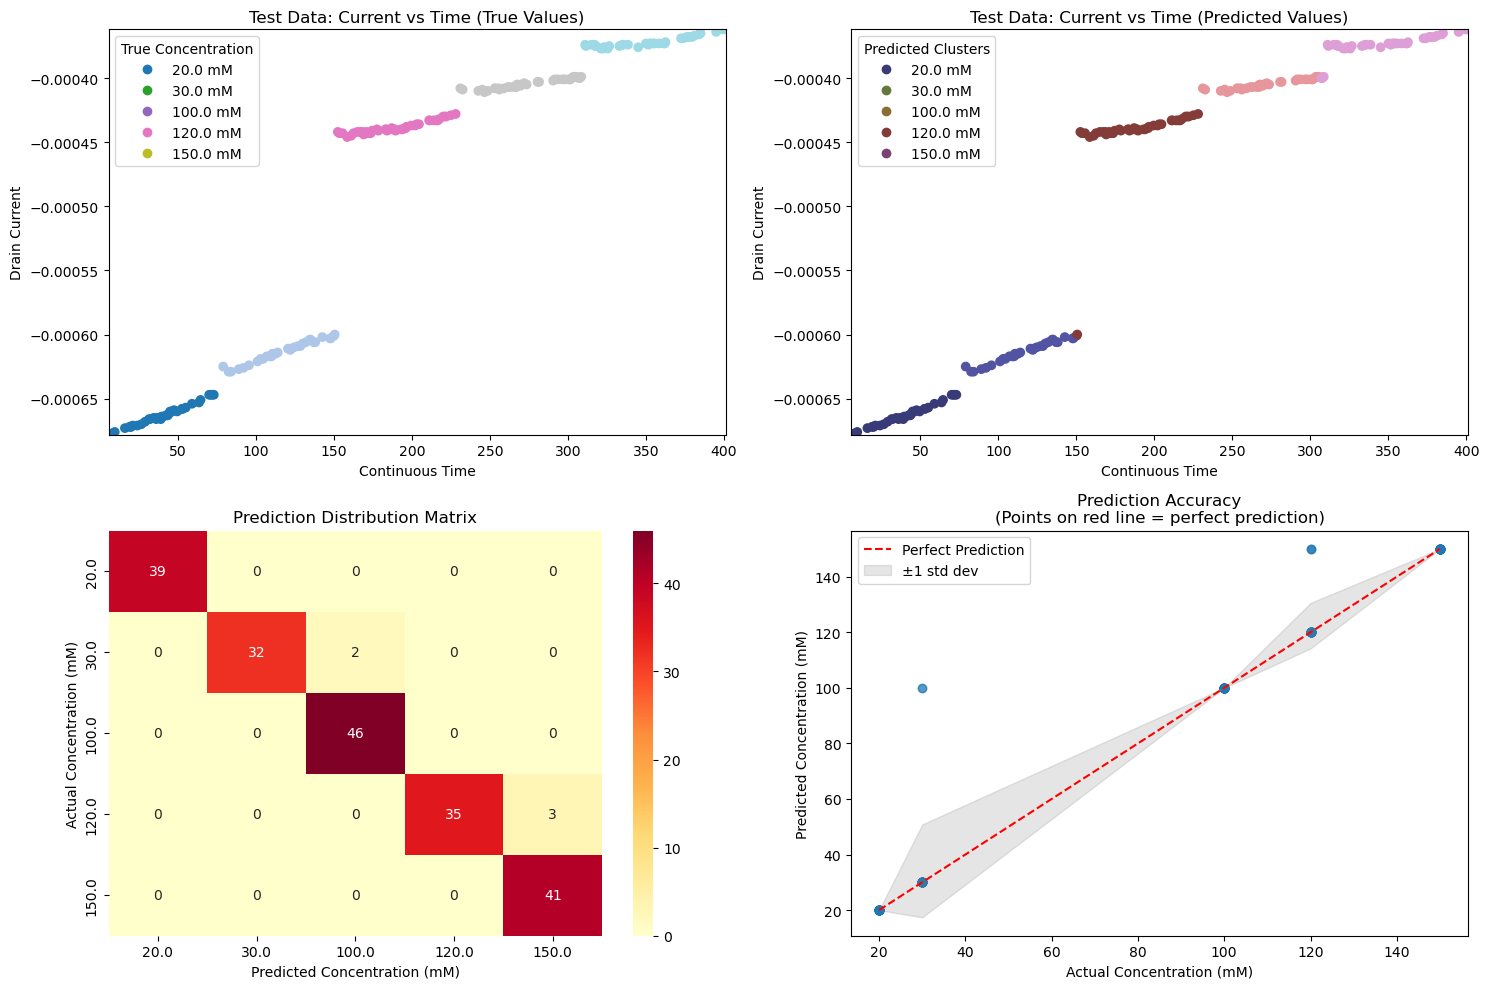


Test Data Analysis:
Total Test Samples: 198
Correct Predictions: 193
Accuracy: 97.47%

Prediction Error Statistics:
Mean Absolute Error: 1.16 mM
Max Error: 70.00 mM
Standard Deviation of Error: 7.86 mM

Shape Information:
X_test shape: (198, 10, 2)
Number of predictions: 198
Number of plot points: 198


In [44]:
plot_enhanced_predictions(model, X_test, y_test, scaler, unique_concentrations,data)